<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 1 | Setup and Analysis</p>

# <b></span><span style='color:#87CEEB'> Importing Necessary Libraries</span></b>

In [545]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
import plotly.graph_objects as go
from tabulate import tabulate



# <b></span><span style='color:#87CEEB'> Load dataware house</span></b>

In [546]:
df_flights = pd.read_csv('Datasets/voos_completos_clima.csv')

# <b></span><span style='color:#87CEEB'> Initial Data Analysis</span></b>

In [547]:
df_flights.head(10)

,nr_voo,data_partida,nome_companhia_aerea,id_companhia_aerea,pais_companhia_aerea,aeroporto_origem,nome_aeroporto_origem,pais_aeroporto_origem,cidade_aeroporto_origem,latitude_aeroporto_origem,...,atraso_voo_anterior,Modelo_Avião,Fabricante,avaliacao,temperatura,precipitacao,visibilidade,cobertura_nuvens,velocidade,direcao
0,1562,2019-01-09,United Airlines,UA,United States,FLL,Fort Lauderdale Hollywood International Airport,United States,Fort Lauderdale,26.072599,...,NaN,Airbus A320,Airbus,2.4,24.707943,2.930989,10.286996,42.902462,17.763297,234.822503
1,1149,2022-11-19,Delta Air Lines,DL,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,United States,Minneapolis,44.882000,...,NaN,Airbus A300,Airbus,7.1,21.894861,3.750816,9.283380,45.925146,5.454128,215.090545
2,459,2022-07-22,United Airlines,UA,United States,DEN,Denver International Airport,United States,Denver,39.861698,...,NaN,Airbus A340,Airbus,4.2,17.453724,4.575866,9.668414,11.275358,18.114917,253.237576
3,2295,2023-03-06,Delta Air Lines,DL,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,United States,Minneapolis,44.882000,...,0.0,Boeing 767-200,Boeing,3.3,21.749921,1.156845,13.642514,45.410799,43.830962,10.760631
4,407,2020-02-23,Spirit Airlines,NK,United States,MCO,Orlando International Airport,United States,Orlando,28.429399,...,NaN,Airbus A330-200,Airbus,0.5,17.241807,1.389318,10.046560,43.422224,10.685583,269.114562
5,665,2019-07-31,Southwest Airlines,WN,United States,DAL,Dallas Love Field,United States,Dallas,32.847099,...,0.0,Boeing 747-400,Boeing,4.8,21.752222,17.694242,8.924453,48.736524,6.768047,336.180597
6,2134,2023-06-11,American Airlines,AA,United States,DCA,Ronald Reagan Washington National Airport,United States,Washington,38.852100,...,NaN,Boeing 787-10,Boeing,5.5,22.709606,3.152942,10.806620,46.453579,16.323853,7.840859
7,4464,2019-07-08,Midwest Airlines,YX,United States,HSV,Huntsville International Carl T Jones Field,United States,Huntsville,34.637199,...,0.0,Boeing 727,Boeing,3.3,24.674139,0.631494,12.180694,39.225293,27.530856,237.178121
8,590,2023-02-12,Spirit Airlines,NK,United States,IAH,George Bush Intercontinental Houston Airport,United States,Houston,29.984400,...,NaN,Airbus A330,Airbus,2.2,24.100101,4.723317,13.826943,0.564220,17.648984,331.737519
9,223,2020-08-22,Alaska Airlines,AS,ALASKA,SEA,Seattle Tacoma International Airport,United States,Seattle,47.449001,...,NaN,Airbus A330-200,Airbus,1.8,20.023194,0.415273,14.443763,8.842384,18.548913,288.860415


In [548]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 38 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   nr_voo                       int64  
 1   data_partida                 object 
 2   nome_companhia_aerea         object 
 3   id_companhia_aerea           object 
 4   pais_companhia_aerea         object 
 5   aeroporto_origem             object 
 6   nome_aeroporto_origem        object 
 7   pais_aeroporto_origem        object 
 8   cidade_aeroporto_origem      object 
 9   latitude_aeroporto_origem    float64
 10  longitude_aeroporto_origem   float64
 11  aeroporto_destino            object 
 12  nome_aeroporto_destino       object 
 13  pais_aeroporto_destino       object 
 14  cidade_aeroporto_destino     object 
 15  latitude_aeroporto_destino   float64
 16  longitude_aeroporto_destino  float64
 17  hora_partida_real            float64
 18  hora_partida_esperada        int64  
 19  

In [549]:
# Summary statistics for numerical variables
df_flights.describe().T

,count,mean,std,min,25%,50%,75%,max
nr_voo,3000000.0,2511.535519,1747.258040,1.000000e+00,1051.000000,2152.000000,3797.000000,9562.000000
latitude_aeroporto_origem,2999265.0,36.688177,6.011262,-1.433100e+01,32.898602,37.362598,40.777199,71.285402
longitude_aeroporto_origem,2999265.0,-94.806949,18.432813,-1.766460e+02,-110.941002,-87.904800,-80.943100,145.729004
latitude_aeroporto_destino,2999238.0,36.684660,6.013082,-1.433100e+01,32.898602,37.362598,40.777199,71.285402
longitude_aeroporto_destino,2999238.0,-94.809625,18.448716,-1.766460e+02,-110.941002,-87.904800,-80.943100,145.729004
hora_partida_real,2922385.0,1329.775913,499.310052,1.000000e+00,916.000000,1323.000000,1739.000000,2400.000000
hora_partida_esperada,3000000.0,1327.061984,485.878854,1.000000e+00,915.000000,1320.000000,1730.000000,2359.000000
hora_chegada_real,2920058.0,1466.511162,531.838349,1.000000e+00,1053.000000,1505.000000,1913.000000,2400.000000
hora_chegada_esperada,3000000.0,1490.560665,511.547566,1.000000e+00,1107.000000,1516.000000,1919.000000,2400.000000
cancelado,3000000.0,0.026380,0.160263,0.000000e+00,0.000000,0.000000,0.000000,1.000000


In [550]:
# Summary statistics for categorical variables
df_flights.describe(include='object').T

,count,unique,top,freq
data_partida,3000000,1704,2019-07-25,2379
nome_companhia_aerea,3000000,18,Southwest Airlines,576470
id_companhia_aerea,3000000,18,WN,576470
pais_companhia_aerea,3000000,2,United States,2899533
aeroporto_origem,2999265,378,ATL,153556
nome_aeroporto_origem,2999265,378,Hartsfield Jackson Atlanta International Airport,153556
pais_aeroporto_origem,2999265,6,United States,2981743
cidade_aeroporto_origem,2999265,362,Chicago,157368
aeroporto_destino,2999238,378,ATL,153569
nome_aeroporto_destino,2999238,378,Hartsfield Jackson Atlanta International Airport,153569


<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 2 | Data Cleaning</p>

# <b></span><span style='color:#87CEEB'> Treating Cancelled and Diverted Flights</span></b>

In [551]:
df_cancelados = df_flights[df_flights["cancelado"] == 1.0].copy()
df_desviados = df_flights[df_flights["desviado"] == 1.0].copy()

In [552]:
diverted_percentage = (df_desviados.shape[0] / df_flights.shape[0]) * 100
cancelled_percentage = (df_cancelados.shape[0] / df_flights.shape[0]) * 100

In [553]:
print(f"Cancelled flights%: {cancelled_percentage:.2f}\n Diverted flights%: {diverted_percentage:.2f}")

Cancelled flights%: 2.64
 Diverted flights%: 0.24


# <b></span><span style='color:#87CEEB'> Handling Nulls</span></b>

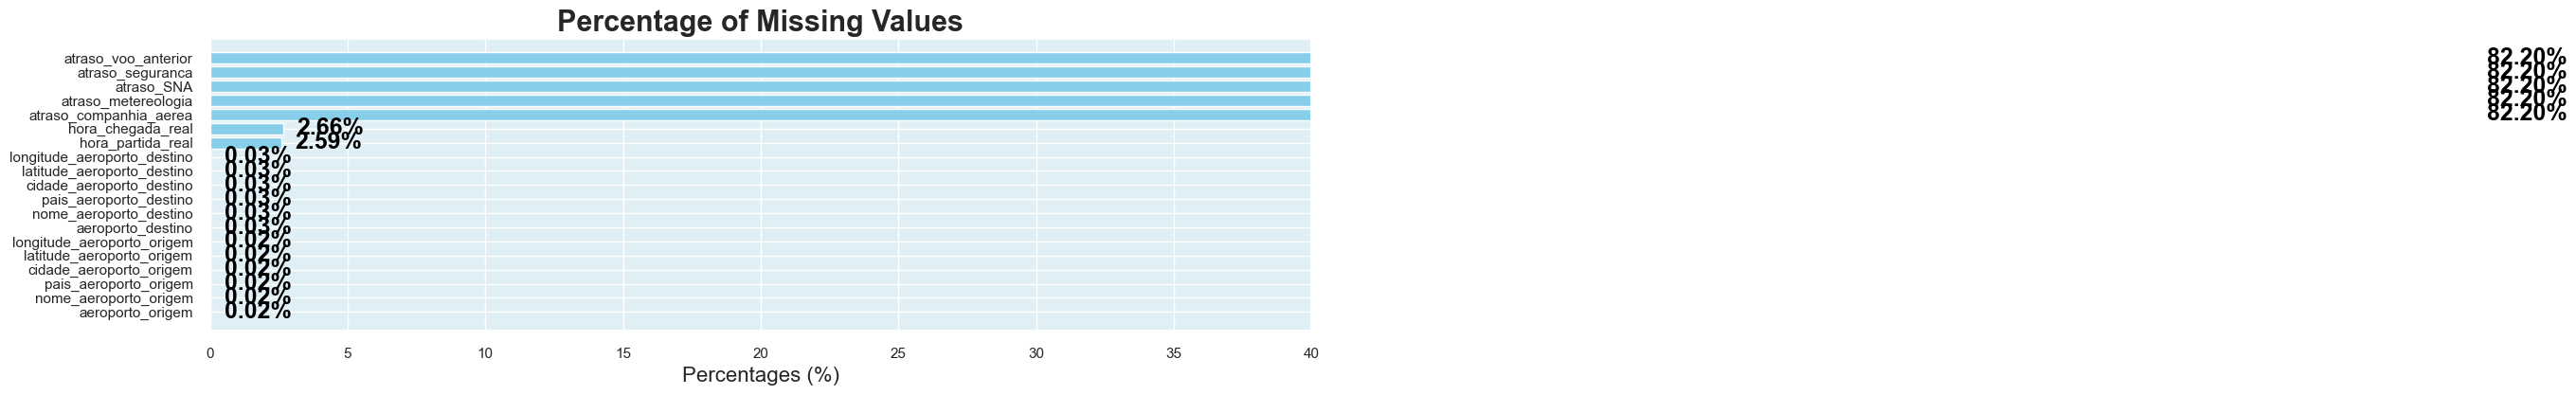

In [554]:
# Calculating the percentage of missing values for each column
missing_data = df_flights.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df_flights.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#87CEEB')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [555]:
df_flights_clean = df_flights.dropna(subset=["hora_partida_real","hora_chegada_real", "longitude_aeroporto_origem", "aeroporto_origem", "aeroporto_destino", "latitude_aeroporto_destino"]).copy()

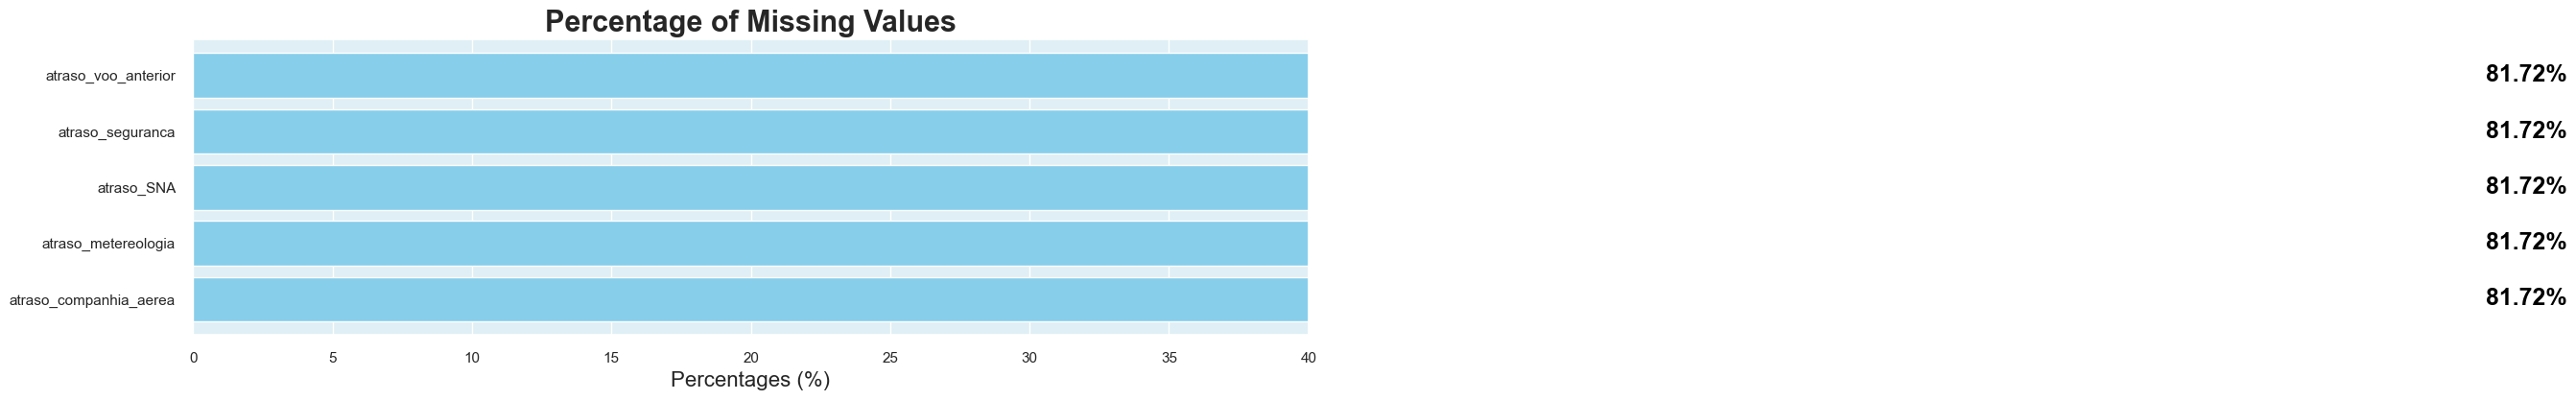

In [556]:
# Calculating the percentage of missing values for each column
missing_data = df_flights_clean.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df_flights_clean.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#87CEEB')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [557]:
def hhmm_to_minutes(hhmm):
    # Converter valores nulos ou inválidos
    try:
        hhmm = int(hhmm)
        hours = hhmm // 100
        minutes = hhmm % 100
        return hours * 60 + minutes
    except:
        return None

# Converter os tempos para minutos
df_flights_clean.loc[:, "DEP_TIME_MIN"] =  df_flights_clean["hora_partida_real"].apply(hhmm_to_minutes)
df_flights_clean.loc[:, "CRS_DEP_TIME_MIN"] =  df_flights_clean["hora_partida_esperada"].apply(hhmm_to_minutes)
df_flights_clean.loc[:, "ARR_TIME_MIN"] =  df_flights_clean["hora_chegada_real"].apply(hhmm_to_minutes)
df_flights_clean.loc[:, "CRS_ARR_TIME_MIN"] =  df_flights_clean["hora_chegada_esperada"].apply(hhmm_to_minutes)

#for col in ["DEP_TIME", "CRS_DEP_TIME", "ARR_TIME", "CRS_ARR_TIME"]:
#    df_flights_clean[col + "_MIN"] = df_flights_clean[col].apply(hhmm_to_minutes)

# Calcular o TOTAL_DELAY
df_flights_clean["atraso_partida"] = (
    df_flights_clean["DEP_TIME_MIN"] - df_flights_clean["CRS_DEP_TIME_MIN"]
)

df_flights_clean["atraso_chegada"] = (
    df_flights_clean["ARR_TIME_MIN"] - df_flights_clean["CRS_ARR_TIME_MIN"]
)


In [558]:
df_flights_clean.head(10)

,nr_voo,data_partida,nome_companhia_aerea,id_companhia_aerea,pais_companhia_aerea,aeroporto_origem,nome_aeroporto_origem,pais_aeroporto_origem,cidade_aeroporto_origem,latitude_aeroporto_origem,...,visibilidade,cobertura_nuvens,velocidade,direcao,DEP_TIME_MIN,CRS_DEP_TIME_MIN,ARR_TIME_MIN,CRS_ARR_TIME_MIN,atraso_partida,atraso_chegada
0,1562,2019-01-09,United Airlines,UA,United States,FLL,Fort Lauderdale Hollywood International Airport,United States,Fort Lauderdale,26.072599,...,10.286996,42.902462,17.763297,234.822503,711,715,887,901,-4,-14
1,1149,2022-11-19,Delta Air Lines,DL,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,United States,Minneapolis,44.882000,...,9.283380,45.925146,5.454128,215.090545,1274,1280,1390,1395,-6,-5
2,459,2022-07-22,United Airlines,UA,United States,DEN,Denver International Airport,United States,Denver,39.861698,...,9.668414,11.275358,18.114917,253.237576,600,594,772,772,6,0
3,2295,2023-03-06,Delta Air Lines,DL,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,United States,Minneapolis,44.882000,...,13.642514,45.410799,43.830962,10.760631,968,969,1133,1109,-1,24
4,407,2020-02-23,Spirit Airlines,NK,United States,MCO,Orlando International Airport,United States,Orlando,28.429399,...,10.046560,43.422224,10.685583,269.114562,1118,1120,1240,1241,-2,-1
5,665,2019-07-31,Southwest Airlines,WN,United States,DAL,Dallas Love Field,United States,Dallas,32.847099,...,8.924453,48.736524,6.768047,336.180597,757,610,811,670,147,141
6,2134,2023-06-11,American Airlines,AA,United States,DCA,Ronald Reagan Washington National Airport,United States,Washington,38.852100,...,10.806620,46.453579,16.323853,7.840859,601,610,690,719,-9,-29
7,4464,2019-07-08,Midwest Airlines,YX,United States,HSV,Huntsville International Carl T Jones Field,United States,Huntsville,34.637199,...,12.180694,39.225293,27.530856,237.178121,997,1003,1208,1185,-6,23
8,590,2023-02-12,Spirit Airlines,NK,United States,IAH,George Bush Intercontinental Houston Airport,United States,Houston,29.984400,...,13.826943,0.564220,17.648984,331.737519,327,330,426,437,-3,-11
9,223,2020-08-22,Alaska Airlines,AS,ALASKA,SEA,Seattle Tacoma International Airport,United States,Seattle,47.449001,...,14.443763,8.842384,18.548913,288.860415,1276,1285,1436,1435,-9,1


In [559]:
df_cancelados1 = df_flights_clean[df_flights_clean["cancelado"] == 1.0].copy()
df_desviados1 = df_flights_clean[df_flights_clean["desviado"] == 1.0].copy()

cancelled_percentage = (df_cancelados1.shape[0] / df_flights_clean.shape[0]) * 100
diverted_percentage = (df_desviados1.shape[0] / df_flights_clean.shape[0]) * 100

print(f"Cancelled flights%: {cancelled_percentage:.2f}\n Diverted flights%: {diverted_percentage:.2f}")


Cancelled flights%: 0.00
 Diverted flights%: 0.21


In [560]:
df_flights_clean = df_flights_clean[(df_flights["desviado"] != 1.0)].copy()

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_28896\1599452511.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [561]:
df_flights_clean.drop(["cancelado", "desviado", "DEP_TIME_MIN", "CRS_DEP_TIME_MIN", "ARR_TIME_MIN", "CRS_ARR_TIME_MIN"], axis=1, inplace=True)

In [562]:
df_flights_clean.head(10)

,nr_voo,data_partida,nome_companhia_aerea,id_companhia_aerea,pais_companhia_aerea,aeroporto_origem,nome_aeroporto_origem,pais_aeroporto_origem,cidade_aeroporto_origem,latitude_aeroporto_origem,...,Fabricante,avaliacao,temperatura,precipitacao,visibilidade,cobertura_nuvens,velocidade,direcao,atraso_partida,atraso_chegada
0,1562,2019-01-09,United Airlines,UA,United States,FLL,Fort Lauderdale Hollywood International Airport,United States,Fort Lauderdale,26.072599,...,Airbus,2.4,24.707943,2.930989,10.286996,42.902462,17.763297,234.822503,-4,-14
1,1149,2022-11-19,Delta Air Lines,DL,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,United States,Minneapolis,44.882000,...,Airbus,7.1,21.894861,3.750816,9.283380,45.925146,5.454128,215.090545,-6,-5
2,459,2022-07-22,United Airlines,UA,United States,DEN,Denver International Airport,United States,Denver,39.861698,...,Airbus,4.2,17.453724,4.575866,9.668414,11.275358,18.114917,253.237576,6,0
3,2295,2023-03-06,Delta Air Lines,DL,United States,MSP,Minneapolis-St Paul International/Wold-Chamber...,United States,Minneapolis,44.882000,...,Boeing,3.3,21.749921,1.156845,13.642514,45.410799,43.830962,10.760631,-1,24
4,407,2020-02-23,Spirit Airlines,NK,United States,MCO,Orlando International Airport,United States,Orlando,28.429399,...,Airbus,0.5,17.241807,1.389318,10.046560,43.422224,10.685583,269.114562,-2,-1
5,665,2019-07-31,Southwest Airlines,WN,United States,DAL,Dallas Love Field,United States,Dallas,32.847099,...,Boeing,4.8,21.752222,17.694242,8.924453,48.736524,6.768047,336.180597,147,141
6,2134,2023-06-11,American Airlines,AA,United States,DCA,Ronald Reagan Washington National Airport,United States,Washington,38.852100,...,Boeing,5.5,22.709606,3.152942,10.806620,46.453579,16.323853,7.840859,-9,-29
7,4464,2019-07-08,Midwest Airlines,YX,United States,HSV,Huntsville International Carl T Jones Field,United States,Huntsville,34.637199,...,Boeing,3.3,24.674139,0.631494,12.180694,39.225293,27.530856,237.178121,-6,23
8,590,2023-02-12,Spirit Airlines,NK,United States,IAH,George Bush Intercontinental Houston Airport,United States,Houston,29.984400,...,Airbus,2.2,24.100101,4.723317,13.826943,0.564220,17.648984,331.737519,-3,-11
9,223,2020-08-22,Alaska Airlines,AS,ALASKA,SEA,Seattle Tacoma International Airport,United States,Seattle,47.449001,...,Airbus,1.8,20.023194,0.415273,14.443763,8.842384,18.548913,288.860415,-9,1


<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 3 | Feature Engineering</p>

# <b></span><span style='color:#87CEEB'> RFM Features</span></b>

<div style="border-radius:10px; padding:15px; background-color:#87CEEB; font-size:120%; text-align:left; color: black;">
  <h2>Recency</h2>
  <p>Vamos usar a <b>recência</b> para analisar quão recente foi o último atraso.</p>

  <h2>Frequency</h2>
  <p>A <b>frequência</b> nos permite descobrir se os atrasos são acontecimentos recorrentes.</p>

  <h2>Monetary</h2>
  <p>Qual é a <b>quantidade</b> total de atrasos? aplicar aos aeroportos? companhias aereas? aos dois? Nem sei se faz sentido aplicar isto aqui ou nao</p>
</div>

# <b></span><span style='color:#87CEEB'> RFM Airline</span></b>

In [563]:
# Convert data_partida to datetime type
df_flights_clean['data_partida'] = pd.to_datetime(df_flights_clean['data_partida'])

# Convert data_partida to datetime and extract only the date
df_flights_clean['data_partida'] = df_flights_clean['data_partida'].dt.date

df_flights_clean['rota'] = df_flights_clean['aeroporto_origem'] + '-' + df_flights_clean['aeroporto_destino']

# Filtrar apenas os voos com atraso na chegada
df_atrasados = df_flights_clean[df_flights_clean['atraso_chegada'] > 0]

In [564]:
#df_atrasados.describe().T

In [565]:
# Calcular última data de atraso por companhia
last_delay = df_atrasados.groupby('id_companhia_aerea')['data_partida'].max().reset_index()
last_delay.rename(columns={'data_partida': 'data_ultimo_atraso'}, inplace=True)

all_airlines = df_flights_clean[['id_companhia_aerea']].drop_duplicates()

# Mesclar para manter todas as companhias, mesmo sem atrasos
airline_data = pd.merge(all_airlines, last_delay, on='id_companhia_aerea', how='left')

# Garantir que a coluna data_ultimo_atraso está no formato datetime
airline_data['data_ultimo_atraso'] = pd.to_datetime(airline_data['data_ultimo_atraso'])

# Calcular data de referência (última data do dataset)
data_base = df_flights_clean['data_partida'].max()
data_base = pd.to_datetime(data_base)

# Calcular recência (dias desde o último atraso)
airline_data['dias_desde_ultimo_atraso'] = (data_base - airline_data['data_ultimo_atraso']).dt.days

airline_data.head()

,id_companhia_aerea,data_ultimo_atraso,dias_desde_ultimo_atraso
0,UA,2023-08-31,0
1,DL,2023-08-31,0
2,NK,2023-08-31,0
3,WN,2023-08-31,0
4,AA,2023-08-31,0


In [566]:
# Calculate the total number of flights made by each airline
nr_total_voos = df_flights_clean['id_companhia_aerea'].value_counts().reset_index()
nr_total_voos.columns = ['id_companhia_aerea', 'nr_total_voos']

# Merge the new features into the airline_data dataframe
airline_data = pd.merge(airline_data, nr_total_voos, on='id_companhia_aerea')

# Display the first few rows of the airline_data dataframe
airline_data.head()

,id_companhia_aerea,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos
0,UA,2023-08-31,0,248270
1,DL,2023-08-31,0,388475
2,NK,2023-08-31,0,93200
3,WN,2023-08-31,0,555869
4,AA,2023-08-31,0,371218


In [567]:
atraso_total = df_flights_clean.groupby('id_companhia_aerea')['atraso_chegada'].sum().reset_index()

# Calculate the average transaction value for each customer
atraso_medio = atraso_total.merge(nr_total_voos, on='id_companhia_aerea')
atraso_medio['atraso_medio'] = atraso_medio['atraso_chegada'] / atraso_medio['nr_total_voos']
atraso_medio['atraso_medio'] = atraso_medio['atraso_medio'].round(2)

# Merge the new features into the airline_data dataframe
airline_data = pd.merge(airline_data, atraso_total, on='id_companhia_aerea')
airline_data = pd.merge(airline_data, atraso_medio[['id_companhia_aerea', 'atraso_medio']], on='id_companhia_aerea')

In [568]:
airline_data.describe().T

,count,mean,min,25%,50%,75%,max,std
data_ultimo_atraso,18,2023-06-05 17:20:00,2020-09-28 00:00:00,2023-08-31 00:00:00,2023-08-31 00:00:00,2023-08-31 00:00:00,2023-08-31 00:00:00,NaN
dias_desde_ultimo_atraso,18.0,86.277778,0.0,0.0,0.0,0.0,1067.0,256.97306
nr_total_voos,18.0,161798.055556,17951.0,62535.5,106465.0,220739.25,555869.0,152898.088512
atraso_chegada,18.0,-2269896.388889,-7048505.0,-2875384.25,-1679015.0,-801081.5,-86784.0,2085805.315882
atraso_medio,18.0,-14.406667,-27.48,-20.8225,-12.795,-9.07,-2.74,7.622923


In [569]:
airline_data.head()

,id_companhia_aerea,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso_chegada,atraso_medio
0,UA,2023-08-31,0,248270,-4367156,-17.59
1,DL,2023-08-31,0,388475,-5797594,-14.92
2,NK,2023-08-31,0,93200,-2477252,-26.58
3,WN,2023-08-31,0,555869,-7048505,-12.68
4,AA,2023-08-31,0,371218,-5436912,-14.65


# <b></span><span style='color:#87CEEB'> RFM Flight</span></b>

In [570]:
# Calcular última data de atraso por companhia
last_delay = df_atrasados.groupby('rota')['data_partida'].max().reset_index()
last_delay.rename(columns={'data_partida': 'data_ultimo_atraso'}, inplace=True)

all_voos = df_flights_clean[['rota']].drop_duplicates()

# Mesclar para manter todas as companhias, mesmo sem atrasos
flight_data = pd.merge(all_voos, last_delay, on='rota', how='left')

# Garantir que a coluna data_ultimo_atraso está no formato datetime
flight_data['data_ultimo_atraso'] = pd.to_datetime(flight_data['data_ultimo_atraso'])

# Calcular data de referência (última data do dataset)
data_base = df_flights_clean['data_partida'].max()
data_base = pd.to_datetime(data_base)

# Calcular recência (dias desde o último atraso)
flight_data['dias_desde_ultimo_atraso'] = (data_base - flight_data['data_ultimo_atraso']).dt.days

flight_data.head()

,rota,data_ultimo_atraso,dias_desde_ultimo_atraso
0,FLL-EWR,2023-08-31,0.0
1,MSP-SEA,2023-08-24,7.0
2,DEN-MSP,2023-08-31,0.0
3,MSP-SFO,2023-08-31,0.0
4,MCO-DFW,2023-08-31,0.0


In [571]:
# Calculate the total number of trips made by each flight
nr_total_voos = df_flights_clean['rota'].value_counts().reset_index()
nr_total_voos.columns = ['rota', 'nr_total_voos']

# Merge the new features into the flight_data dataframe
flight_data = pd.merge(flight_data, nr_total_voos, on='rota')

# Display the first few rows of the flight_data dataframe
flight_data.head()

,rota,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos
0,FLL-EWR,2023-08-31,0.0,2253
1,MSP-SEA,2023-08-24,7.0,1212
2,DEN-MSP,2023-08-31,0.0,2434
3,MSP-SFO,2023-08-31,0.0,798
4,MCO-DFW,2023-08-31,0.0,1897


In [572]:
atraso_total = df_flights_clean.groupby('rota')['atraso_chegada'].sum().reset_index()

# Calculate the average transaction value for each customer
atraso_medio = atraso_total.merge(nr_total_voos, on='rota')
atraso_medio['atraso_medio'] = atraso_medio['atraso_chegada'] / atraso_medio['nr_total_voos']
atraso_medio['atraso_medio'] = atraso_medio['atraso_medio'].round(2)

# Merge the new features into the flight_data dataframe
flight_data = pd.merge(flight_data, atraso_total, on='rota')
flight_data = pd.merge(flight_data, atraso_medio[['rota', 'atraso_medio']], on='rota')

In [573]:
flight_data.describe().T

,count,mean,min,25%,50%,75%,max,std
data_ultimo_atraso,7492,2023-02-21 08:49:31.489588992,2019-01-01 00:00:00,2023-04-03 00:00:00,2023-08-11 00:00:00,2023-08-26 00:00:00,2023-08-31 00:00:00,NaN
dias_desde_ultimo_atraso,7492.0,190.632274,0.0,5.0,20.0,150.0,1703.0,370.181092
nr_total_voos,7755.0,375.546744,1.0,36.0,165.0,501.5,5218.0,534.472427
atraso_chegada,7755.0,-5268.618311,-135986.0,-5015.5,-496.0,117.5,29788.0,12240.264793
atraso_medio,7755.0,-13.213613,-1291.0,-18.11,-4.81,2.43,843.29,46.01932


In [574]:
flight_data.head()

,rota,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso_chegada,atraso_medio
0,FLL-EWR,2023-08-31,0.0,2253,-135986,-60.36
1,MSP-SEA,2023-08-24,7.0,1212,-12015,-9.91
2,DEN-MSP,2023-08-31,0.0,2434,-73699,-30.28
3,MSP-SFO,2023-08-31,0.0,798,-16353,-20.49
4,MCO-DFW,2023-08-31,0.0,1897,-19990,-10.54


# <b></span><span style='color:#87CEEB'> RFM Airport</span></b>

In [575]:
# Para partidas
df_partida = df_flights_clean[['aeroporto_origem', 'atraso_partida', 'data_partida']].copy()
df_partida = df_partida.rename(columns={
    'aeroporto_origem': 'aeroporto',
    'atraso_partida': 'atraso'
})

# Para chegadas
df_chegada = df_flights_clean[['aeroporto_destino', 'atraso_chegada', 'data_partida']].copy()
df_chegada = df_chegada.rename(columns={
    'aeroporto_destino': 'aeroporto',
    'atraso_chegada': 'atraso'
})

# Combinar ambos
df_combined = pd.concat([df_partida, df_chegada], ignore_index=True)

# Converter data_partida para datetime, se necessário
df_combined['data_partida'] = pd.to_datetime(df_combined['data_partida'])

todos_aeroportos = df_combined[['aeroporto']].drop_duplicates()

# Filtrar apenas voos com atraso positivo
df_atrasados = df_combined[df_combined['atraso'] > 0]

In [576]:
# 7. Agrupar para obter a última data com atraso
last_delay = df_atrasados.groupby(['aeroporto'])['data_partida'].max().reset_index()
last_delay.rename(columns={'data_partida': 'data_ultimo_atraso'}, inplace=True)

# 8. Combinar com todos os aeroportos (para manter os sem atraso)
airport_data = todos_aeroportos.merge(last_delay, on=['aeroporto'], how='left')

# 9. Calcular data base (data mais recente do dataset)
data_base = df_combined['data_partida'].max()
data_base = pd.to_datetime(data_base)

# 10. Calcular recência (dias desde o último atraso)
airport_data['dias_desde_ultimo_atraso'] = (data_base - airport_data['data_ultimo_atraso']).dt.days

In [577]:
# 1. Contar partidas por aeroporto
voos_partida = df_flights_clean['aeroporto_origem'].value_counts().reset_index()
voos_partida.columns = ['aeroporto', 'voos_partida']

# 2. Contar chegadas por aeroporto
voos_chegada = df_flights_clean['aeroporto_destino'].value_counts().reset_index()
voos_chegada.columns = ['aeroporto', 'voos_chegada']

# 3. Juntar os dois
nr_total_voos = pd.merge(voos_partida, voos_chegada, on='aeroporto', how='outer')

# 5. Calcular total
nr_total_voos['nr_total_voos'] = nr_total_voos['voos_partida'] + nr_total_voos['voos_chegada']


# 6. Mesclar com airport_data
airport_data = pd.merge(airport_data, nr_total_voos[['aeroporto', 'nr_total_voos']], on='aeroporto', how='left')

# Display the first few rows of the airport_data dataframe
airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos
0,FLL,2023-08-31,0,78045
1,MSP,2023-08-31,0,117099
2,DEN,2023-08-31,0,231352
3,MCO,2023-08-31,0,123816
4,DAL,2023-08-31,0,58843


In [578]:
# Garantir que a coluna 'atraso' seja numérica (evita erros)
df_combined['atraso'] = pd.to_numeric(df_combined['atraso'], errors='coerce')

# Agrupar por aeroporto e tipo, somando os atrasos
atraso_total = df_combined.groupby(['aeroporto'])['atraso'].sum().reset_index()

# Calculate the average transaction value for each customer
atraso_medio = atraso_total.merge(nr_total_voos, on='aeroporto')
atraso_medio['atraso_medio'] = atraso_medio['atraso'] / atraso_medio['nr_total_voos']
atraso_medio['atraso_medio'] = atraso_medio['atraso_medio'].round(2)

# Merge the new features into the airport_data dataframe
airport_data = pd.merge(airport_data, atraso_total, on='aeroporto')
airport_data = pd.merge(airport_data, atraso_medio[['aeroporto', 'atraso_medio']], on='aeroporto')

In [579]:
airport_data.describe().T

,count,mean,min,25%,50%,75%,max,std
data_ultimo_atraso,378,2023-07-04 04:03:48.571428608,2019-04-28 00:00:00,2023-08-20 06:00:00,2023-08-29 00:00:00,2023-08-31 00:00:00,2023-08-31 00:00:00,NaN
dias_desde_ultimo_atraso,378.0,57.830688,0.0,0.0,2.0,10.75,1586.0,196.749333
nr_total_voos,378.0,15409.338624,17.0,650.0,2182.5,9370.5,301499.0,37686.011174
atraso,378.0,-80792.441799,-1818473.0,-59452.25,-8154.5,118.75,344002.0,216973.940291
atraso_medio,378.0,-5.124312,-124.79,-9.435,-3.92,0.1475,47.17,11.203382


In [580]:
airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio
0,FLL,2023-08-31,0,78045,-621037,-7.96
1,MSP,2023-08-31,0,117099,-412071,-3.52
2,DEN,2023-08-31,0,231352,-359322,-1.55
3,MCO,2023-08-31,0,123816,-1072201,-8.66
4,DAL,2023-08-31,0,58843,-193820,-3.29


# <b></span><span style='color:#87CEEB'> Flight Diversity</span></b>

In [581]:
#ta mal

# Calculate the number of unique products purchased by each airline
unique_flights = df_flights_clean.groupby('aeroporto_origem')['nr_voo'].nunique().reset_index()
unique_flights.rename(columns={'nr_voo': 'Unique_Flights'}, inplace=True)

# Merge the new feature into the airport_data dataframe
airport_data = pd.merge(airport_data, unique_flights, left_on='aeroporto', right_on='aeroporto_origem')

# Display the first few rows of the airport_data dataframe
airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,aeroporto_origem,Unique_Flights
0,FLL,2023-08-31,0,78045,-621037,-7.96,FLL,3271
1,MSP,2023-08-31,0,117099,-412071,-3.52,MSP,4055
2,DEN,2023-08-31,0,231352,-359322,-1.55,DEN,5843
3,MCO,2023-08-31,0,123816,-1072201,-8.66,MCO,4522
4,DAL,2023-08-31,0,58843,-193820,-3.29,DAL,4714


# <b></span><span style='color:#87CEEB'> Rotas por aeroporto</span></b>

In [582]:
rotas_por_origem = df_flights_clean.groupby('aeroporto_origem')['aeroporto_destino'].nunique().reset_index()
rotas_por_origem.rename(columns={
    'aeroporto_destino': 'nr_rotas_distintas',
    'aeroporto_origem': 'aeroporto'
    }, inplace=True)

rotas_por_destino = df_flights_clean.groupby('aeroporto_destino')['aeroporto_origem'].nunique().reset_index()
rotas_por_destino.rename(columns={
    'aeroporto_origem': 'nr_rotas_distintas',
    'aeroporto_destino': 'aeroporto'
    }, inplace=True)

# Concatenate the two DataFrames
rotas_por_aeroporto = pd.concat([rotas_por_origem, rotas_por_destino])

# Group by airport and sum the number of distinct routes
rotas_por_aeroporto = rotas_por_aeroporto.groupby('aeroporto', as_index=False)['nr_rotas_distintas'].sum()

airport_data = pd.merge(airport_data, rotas_por_aeroporto, on='aeroporto', how='left')

#airport_data.drop(columns='aeroporto_origem', inplace=True)

airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,aeroporto_origem,Unique_Flights,nr_rotas_distintas
0,FLL,2023-08-31,0,78045,-621037,-7.96,FLL,3271,190
1,MSP,2023-08-31,0,117099,-412071,-3.52,MSP,4055,279
2,DEN,2023-08-31,0,231352,-359322,-1.55,DEN,5843,395
3,MCO,2023-08-31,0,123816,-1072201,-8.66,MCO,4522,217
4,DAL,2023-08-31,0,58843,-193820,-3.29,DAL,4714,155


# <b></span><span style='color:#87CEEB'> Distancia media aeroporto</span></b>

In [583]:
# Média da distância por aeroporto de origem
distancia_por_origem = df_flights_clean.groupby('aeroporto_origem')['distancia'].mean().reset_index()
distancia_por_origem.rename(columns={
    'aeroporto_origem': 'aeroporto',
    'distancia': 'distancia_media'
}, inplace=True)

# Média da distância por aeroporto de destino
distancia_por_destino = df_flights_clean.groupby('aeroporto_destino')['distancia'].mean().reset_index()
distancia_por_destino.rename(columns={
    'aeroporto_destino': 'aeroporto',
    'distancia': 'distancia_media'
}, inplace=True)

# Concatenar e calcular média geral por aeroporto
distancia_por_aeroporto = pd.concat([distancia_por_origem, distancia_por_destino])
distancia_por_aeroporto = distancia_por_aeroporto.groupby('aeroporto', as_index=False)['distancia_media'].mean()

# Merge no airport_data
airport_data = pd.merge(airport_data, distancia_por_aeroporto, on='aeroporto', how='left')

airport_data.head()


,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,aeroporto_origem,Unique_Flights,nr_rotas_distintas,distancia_media
0,FLL,2023-08-31,0,78045,-621037,-7.96,FLL,3271,190,1043.026575
1,MSP,2023-08-31,0,117099,-412071,-3.52,MSP,4055,279,787.530555
2,DEN,2023-08-31,0,231352,-359322,-1.55,DEN,5843,395,874.622375
3,MCO,2023-08-31,0,123816,-1072201,-8.66,MCO,4522,217,971.344573
4,DAL,2023-08-31,0,58843,-193820,-3.29,DAL,4714,155,715.731498


# <b></span><span style='color:#87CEEB'> Distancia flight</span></b>


In [584]:
df_merge = df_flights_clean[['rota', 'distancia']].drop_duplicates()

flight_data = pd.merge(
    flight_data,
    df_merge,
    on='rota',
)

In [585]:
flight_data.head()

,rota,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso_chegada,atraso_medio,distancia
0,FLL-EWR,2023-08-31,0.0,2253,-135986,-60.36,1065.0
1,MSP-SEA,2023-08-24,7.0,1212,-12015,-9.91,1399.0
2,DEN-MSP,2023-08-31,0.0,2434,-73699,-30.28,680.0
3,MSP-SFO,2023-08-31,0.0,798,-16353,-20.49,1589.0
4,MCO-DFW,2023-08-31,0.0,1897,-19990,-10.54,985.0


# <b></span><span style='color:#87CEEB'> Companhias por aeroporto</span></b>


In [586]:
# Pegar os pares (aeroporto, companhia) tanto de origem quanto de destino
companhias_origem = df_flights_clean[['aeroporto_origem', 'id_companhia_aerea']].rename(
    columns={'aeroporto_origem': 'aeroporto'}
)

companhias_destino = df_flights_clean[['aeroporto_destino', 'id_companhia_aerea']].rename(
    columns={'aeroporto_destino': 'aeroporto'}
)

# Concatenar os dois
companhias_total = pd.concat([companhias_origem, companhias_destino])

# Remover duplicatas (aeroporto, companhia)
companhias_total = companhias_total.drop_duplicates()

# Agora contar o número de companhias únicas por aeroporto
nr_companhias_por_aeroporto = companhias_total.groupby('aeroporto')['id_companhia_aerea'].nunique().reset_index()
nr_companhias_por_aeroporto.rename(columns={'id_companhia_aerea': 'nr_companhias_distintas'}, inplace=True)

# Fazer o merge com airport_data
airport_data = pd.merge(airport_data, nr_companhias_por_aeroporto, on='aeroporto', how='left')


airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,aeroporto_origem,Unique_Flights,nr_rotas_distintas,distancia_media,nr_companhias_distintas
0,FLL,2023-08-31,0,78045,-621037,-7.96,FLL,3271,190,1043.026575,13
1,MSP,2023-08-31,0,117099,-412071,-3.52,MSP,4055,279,787.530555,17
2,DEN,2023-08-31,0,231352,-359322,-1.55,DEN,5843,395,874.622375,14
3,MCO,2023-08-31,0,123816,-1072201,-8.66,MCO,4522,217,971.344573,11
4,DAL,2023-08-31,0,58843,-193820,-3.29,DAL,4714,155,715.731498,6


# <b></span><span style='color:#87CEEB'> Rating por aeroporto</span></b>

In [587]:
# Média da distância por aeroporto de origem
avaliacao_por_origem = df_flights_clean.groupby('aeroporto_origem')['avaliacao'].mean().reset_index()
avaliacao_por_origem.rename(columns={
    'aeroporto_origem': 'aeroporto',
    'avaliacao': 'avaliacao_media'
}, inplace=True)

# Média da distância por aeroporto de destino
avaliacao_por_destino = df_flights_clean.groupby('aeroporto_destino')['avaliacao'].mean().reset_index()
avaliacao_por_destino.rename(columns={
    'aeroporto_destino': 'aeroporto',
    'avaliacao': 'avaliacao_media'
}, inplace=True)

# Concatenar e calcular média geral por aeroporto
avaliacao_por_aeroporto = pd.concat([avaliacao_por_origem, avaliacao_por_destino])
avaliacao_por_aeroporto = avaliacao_por_aeroporto.groupby('aeroporto', as_index=False)['avaliacao_media'].mean()

# Merge no airport_data
airport_data = pd.merge(airport_data, avaliacao_por_aeroporto, on='aeroporto', how='left')

airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,aeroporto_origem,Unique_Flights,nr_rotas_distintas,distancia_media,nr_companhias_distintas,avaliacao_media
0,FLL,2023-08-31,0,78045,-621037,-7.96,FLL,3271,190,1043.026575,13,3.347044
1,MSP,2023-08-31,0,117099,-412071,-3.52,MSP,4055,279,787.530555,17,3.389200
2,DEN,2023-08-31,0,231352,-359322,-1.55,DEN,5843,395,874.622375,14,3.390244
3,MCO,2023-08-31,0,123816,-1072201,-8.66,MCO,4522,217,971.344573,11,3.390910
4,DAL,2023-08-31,0,58843,-193820,-3.29,DAL,4714,155,715.731498,6,3.395992


# <b></span><span style='color:#87CEEB'> Clima por aeroporto</span></b>


In [588]:
precipitacao_media = df_flights_clean.groupby('aeroporto_origem')['precipitacao'].mean().reset_index()
precipitacao_media.rename(columns={'precipitacao': 'precipitacao_media'}, inplace=True)

airport_data = pd.merge(
    airport_data,
    precipitacao_media,
    left_on='aeroporto',
    right_on='aeroporto_origem',
    how='left'
)


airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,aeroporto_origem_x,Unique_Flights,nr_rotas_distintas,distancia_media,nr_companhias_distintas,avaliacao_media,aeroporto_origem_y,precipitacao_media
0,FLL,2023-08-31,0,78045,-621037,-7.96,FLL,3271,190,1043.026575,13,3.347044,FLL,4.517948
1,MSP,2023-08-31,0,117099,-412071,-3.52,MSP,4055,279,787.530555,17,3.389200,MSP,3.812376
2,DEN,2023-08-31,0,231352,-359322,-1.55,DEN,5843,395,874.622375,14,3.390244,DEN,4.618474
3,MCO,2023-08-31,0,123816,-1072201,-8.66,MCO,4522,217,971.344573,11,3.390910,MCO,4.752549
4,DAL,2023-08-31,0,58843,-193820,-3.29,DAL,4714,155,715.731498,6,3.395992,DAL,4.467013


In [589]:
airport_data.drop(columns={'aeroporto_origem_x','aeroporto_origem_y'}, inplace=True)

In [590]:
visibilidade_media = df_flights_clean.groupby('aeroporto_origem')['visibilidade'].mean().reset_index()
visibilidade_media.rename(columns={'visibilidade': 'visibilidade_media'}, inplace=True)

airport_data = pd.merge(
    airport_data,
    visibilidade_media,
    left_on='aeroporto',
    right_on='aeroporto_origem',
    how='left'
)

airport_data.drop(columns='aeroporto_origem', inplace=True)

airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,nr_rotas_distintas,distancia_media,nr_companhias_distintas,avaliacao_media,precipitacao_media,visibilidade_media
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,190,1043.026575,13,3.347044,4.517948,11.541156
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,279,787.530555,17,3.389200,3.812376,11.542060
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,395,874.622375,14,3.390244,4.618474,11.627970
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,217,971.344573,11,3.390910,4.752549,11.616008
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,155,715.731498,6,3.395992,4.467013,11.659083


In [591]:
cobertura_nuvens_media = df_flights_clean.groupby('aeroporto_origem')['cobertura_nuvens'].mean().reset_index()
cobertura_nuvens_media.rename(columns={'cobertura_nuvens': 'cobertura_nuvens_media'}, inplace=True)

airport_data = pd.merge(
    airport_data,
    cobertura_nuvens_media,
    left_on='aeroporto',
    right_on='aeroporto_origem',
    how='left'
)

airport_data.drop(columns='aeroporto_origem', inplace=True)

airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,nr_rotas_distintas,distancia_media,nr_companhias_distintas,avaliacao_media,precipitacao_media,visibilidade_media,cobertura_nuvens_media
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,190,1043.026575,13,3.347044,4.517948,11.541156,26.638815
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,279,787.530555,17,3.389200,3.812376,11.542060,25.820449
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,395,874.622375,14,3.390244,4.618474,11.627970,25.941459
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,217,971.344573,11,3.390910,4.752549,11.616008,26.731785
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,155,715.731498,6,3.395992,4.467013,11.659083,25.753867


In [592]:
velocidade_media = df_flights_clean.groupby('aeroporto_origem')['velocidade'].mean().reset_index()
velocidade_media.rename(columns={'velocidade': 'velocidade_media'}, inplace=True)

airport_data = pd.merge(
    airport_data,
    velocidade_media,
    left_on='aeroporto',
    right_on='aeroporto_origem',
    how='left'
)

airport_data.drop(columns='aeroporto_origem', inplace=True)

airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,nr_rotas_distintas,distancia_media,nr_companhias_distintas,avaliacao_media,precipitacao_media,visibilidade_media,cobertura_nuvens_media,velocidade_media
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,190,1043.026575,13,3.347044,4.517948,11.541156,26.638815,16.251554
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,279,787.530555,17,3.389200,3.812376,11.542060,25.820449,14.692232
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,395,874.622375,14,3.390244,4.618474,11.627970,25.941459,15.206182
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,217,971.344573,11,3.390910,4.752549,11.616008,26.731785,16.344739
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,155,715.731498,6,3.395992,4.467013,11.659083,25.753867,14.764110


In [593]:
direcao_media = df_flights_clean.groupby('aeroporto_origem')['direcao'].mean().reset_index()
direcao_media.rename(columns={'direcao': 'direcao_media'}, inplace=True)

airport_data = pd.merge(
    airport_data,
    direcao_media,
    left_on='aeroporto',
    right_on='aeroporto_origem',
    how='left'
)

airport_data.drop(columns='aeroporto_origem', inplace=True)

airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,nr_rotas_distintas,distancia_media,nr_companhias_distintas,avaliacao_media,precipitacao_media,visibilidade_media,cobertura_nuvens_media,velocidade_media,direcao_media
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,190,1043.026575,13,3.347044,4.517948,11.541156,26.638815,16.251554,182.028636
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,279,787.530555,17,3.389200,3.812376,11.542060,25.820449,14.692232,180.302748
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,395,874.622375,14,3.390244,4.618474,11.627970,25.941459,15.206182,182.261818
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,217,971.344573,11,3.390910,4.752549,11.616008,26.731785,16.344739,182.480104
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,155,715.731498,6,3.395992,4.467013,11.659083,25.753867,14.764110,183.921931


# <b></span><span style='color:#87CEEB'> Behavioral Features</span></b>

In [594]:
# Garantir datetime
df_flights_clean['data_partida'] = pd.to_datetime(df_flights_clean['data_partida'])

# Extração de dia da semana e mês
df_flights_clean['Day_Of_Week'] = df_flights_clean['data_partida'].dt.dayofweek
df_flights_clean['Month'] = df_flights_clean['data_partida'].dt.month
df_flights_clean['Hour'] = df_flights_clean['data_partida'].dt.hour

# Função para calcular métricas por tipo de aeroporto
def get_delay_metrics(df, col_aeroporto):
    # Dias entre voos (intervalos)
    days_between = df.groupby(col_aeroporto)['data_partida'].apply(
        lambda x: x.sort_values().diff().dropna().dt.days
    )
    avg_days_between = days_between.groupby(col_aeroporto).mean().reset_index()
    avg_days_between.rename(columns={'data_partida': f'{col_aeroporto}_avg_days_between'}, inplace=True)

    # Mes com mais voos (proxy para "mais atrasos")
    month_max = df.groupby([col_aeroporto, 'Month']).size().reset_index(name='Count')
    month_max = month_max.loc[month_max.groupby(col_aeroporto)['Count'].idxmax()][[col_aeroporto, 'Month']]
    month_max.rename(columns={'Month': f'{col_aeroporto}_peak_month'}, inplace=True)

    # Dia da semana com mais voos (proxy para "mais atrasos")
    day_max = df.groupby([col_aeroporto, 'Day_Of_Week']).size().reset_index(name='Count')
    day_max = day_max.loc[day_max.groupby(col_aeroporto)['Count'].idxmax()][[col_aeroporto, 'Day_Of_Week']]
    day_max.rename(columns={'Day_Of_Week': f'{col_aeroporto}_peak_day'}, inplace=True)

    # Hora do dia com mais voos
    hour_max = df.groupby([col_aeroporto, 'Hour']).size().reset_index(name='Count')
    hour_max = hour_max.loc[hour_max.groupby(col_aeroporto)['Count'].idxmax()][[col_aeroporto, 'Hour']]
    hour_max.rename(columns={'Hour': f'{col_aeroporto}_peak_hour'}, inplace=True)

    return avg_days_between, day_max, hour_max, month_max

# Métricas para origem
avg_days_o, peak_day_o, peak_hour_o, month_max_o = get_delay_metrics(df_flights_clean, 'aeroporto_origem')
# Métricas para destino
avg_days_d, peak_day_d, peak_hour_d, month_max_d = get_delay_metrics(df_flights_clean, 'aeroporto_destino')

# Merge com airport_data (usando 'aeroporto' como chave)
for df in [avg_days_o, peak_day_o, peak_hour_o, month_max_o,
           avg_days_d, peak_day_d, peak_hour_d, month_max_d]:
    airport_data = pd.merge(airport_data, df, left_on='aeroporto', right_on=df.columns[0], how='left')
    airport_data.drop(columns=df.columns[0], inplace=True)


In [595]:
airport_data.head()

,aeroporto,data_ultimo_atraso,dias_desde_ultimo_atraso,nr_total_voos,atraso,atraso_medio,Unique_Flights,nr_rotas_distintas,distancia_media,nr_companhias_distintas,...,velocidade_media,direcao_media,aeroporto_origem_avg_days_between,aeroporto_origem_peak_day,aeroporto_origem_peak_hour,aeroporto_origem_peak_month,aeroporto_destino_avg_days_between,aeroporto_destino_peak_day,aeroporto_destino_peak_hour,aeroporto_destino_peak_month
0,FLL,2023-08-31,0,78045,-621037,-7.96,3271,190,1043.026575,13,...,16.251554,182.028636,0.043564,6,0,3,0.043722,6,0,3
1,MSP,2023-08-31,0,117099,-412071,-3.52,4055,279,787.530555,17,...,14.692232,180.302748,0.029010,0,0,8,0.029164,0,0,8
2,DEN,2023-08-31,0,231352,-359322,-1.55,5843,395,874.622375,14,...,15.206182,182.261818,0.014691,0,0,8,0.014753,4,0,8
3,MCO,2023-08-31,0,123816,-1072201,-8.66,4522,217,971.344573,11,...,16.344739,182.480104,0.027456,5,0,3,0.027562,5,0,3
4,DAL,2023-08-31,0,58843,-193820,-3.29,4714,155,715.731498,6,...,14.764110,183.921931,0.057584,3,0,8,0.058188,4,0,7


In [596]:
airport_data = airport_data.drop(columns=['data_ultimo_atraso','atraso'])

In [597]:
airport_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   aeroporto                           378 non-null    object 
 1   dias_desde_ultimo_atraso            378 non-null    int64  
 2   nr_total_voos                       378 non-null    int64  
 3   atraso_medio                        378 non-null    float64
 4   Unique_Flights                      378 non-null    int64  
 5   nr_rotas_distintas                  378 non-null    int64  
 6   distancia_media                     378 non-null    float64
 7   nr_companhias_distintas             378 non-null    int64  
 8   avaliacao_media                     378 non-null    float64
 9   precipitacao_media                  378 non-null    float64
 10  visibilidade_media                  378 non-null    float64
 11  cobertura_nuvens_media              378 non-n

In [598]:
airport_data.describe().T


,count,mean,std,min,25%,50%,75%,max
dias_desde_ultimo_atraso,378.0,57.830688,196.749333,0.000000,0.000000,2.000000,10.750000,1586.000000
nr_total_voos,378.0,15409.338624,37686.011174,17.000000,650.000000,2182.500000,9370.500000,301499.000000
atraso_medio,378.0,-5.124312,11.203382,-124.790000,-9.435000,-3.920000,0.147500,47.170000
Unique_Flights,378.0,739.444444,1252.995125,1.000000,31.000000,151.000000,765.250000,5843.000000
nr_rotas_distintas,378.0,41.031746,65.788900,2.000000,5.000000,13.500000,43.750000,396.000000
distancia_media,378.0,525.142879,309.565824,41.000000,301.443456,483.330698,661.757861,2599.000000
nr_companhias_distintas,378.0,6.103175,5.109666,1.000000,1.000000,4.000000,11.000000,17.000000
avaliacao_media,378.0,3.345571,0.331963,2.031106,3.333602,3.384850,3.412388,5.168889
precipitacao_media,378.0,3.813272,0.599526,2.442621,3.524507,3.703514,4.022531,9.822106
visibilidade_media,378.0,11.563912,0.200015,9.842025,11.539322,11.584049,11.632686,12.137915


<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 4 | Outlier Detection and Treatment</p>

In [599]:
from sklearn.ensemble import IsolationForest

airport_data_numerical = airport_data.select_dtypes(include=['float64', 'int64'])

model = IsolationForest(contamination=0.05, random_state=0)

airport_data['Outlier_Scores'] = model.fit_predict(airport_data_numerical.to_numpy())

# Marcar outliers: 1 = inlier, -1 = outlier → transformamos para 0/1
airport_data['Is_Outlier'] = [1 if x == -1 else 0 for x in airport_data['Outlier_Scores']]

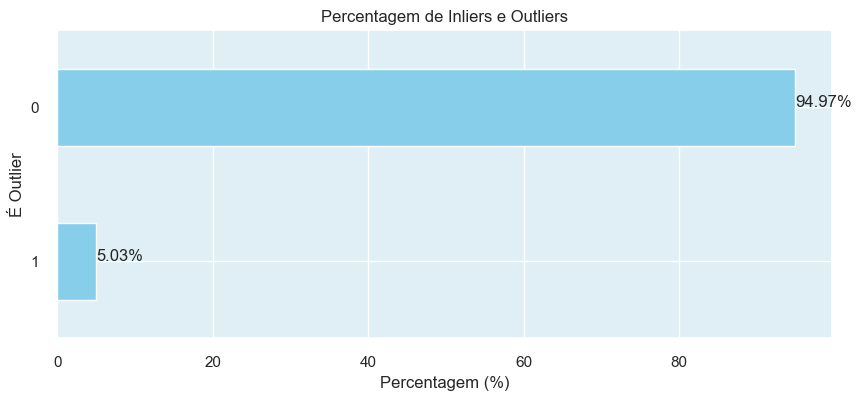

In [600]:
outlier_percentage = airport_data['Is_Outlier'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 4))
outlier_percentage.plot(kind='barh', color='#87CEEB')

for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=12)

plt.title('Percentagem de Inliers e Outliers')
plt.xlabel('Percentagem (%)')
plt.ylabel('É Outlier')
plt.gca().invert_yaxis()
plt.show()

In [601]:
# Guardar os outliers
airport_outliers = airport_data[airport_data['Is_Outlier'] == 1]

# Remover os outliers
airport_data_cleaned = airport_data[airport_data['Is_Outlier'] == 0].copy()

# Remover colunas auxiliares
airport_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'], inplace=True)

# Reset índice
airport_data_cleaned.reset_index(drop=True, inplace=True)

In [602]:
airport_data_cleaned.shape[0]

359

In [603]:
rs_airport = airport_data_cleaned.copy()

<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 5 | Correlation Analysis</p>

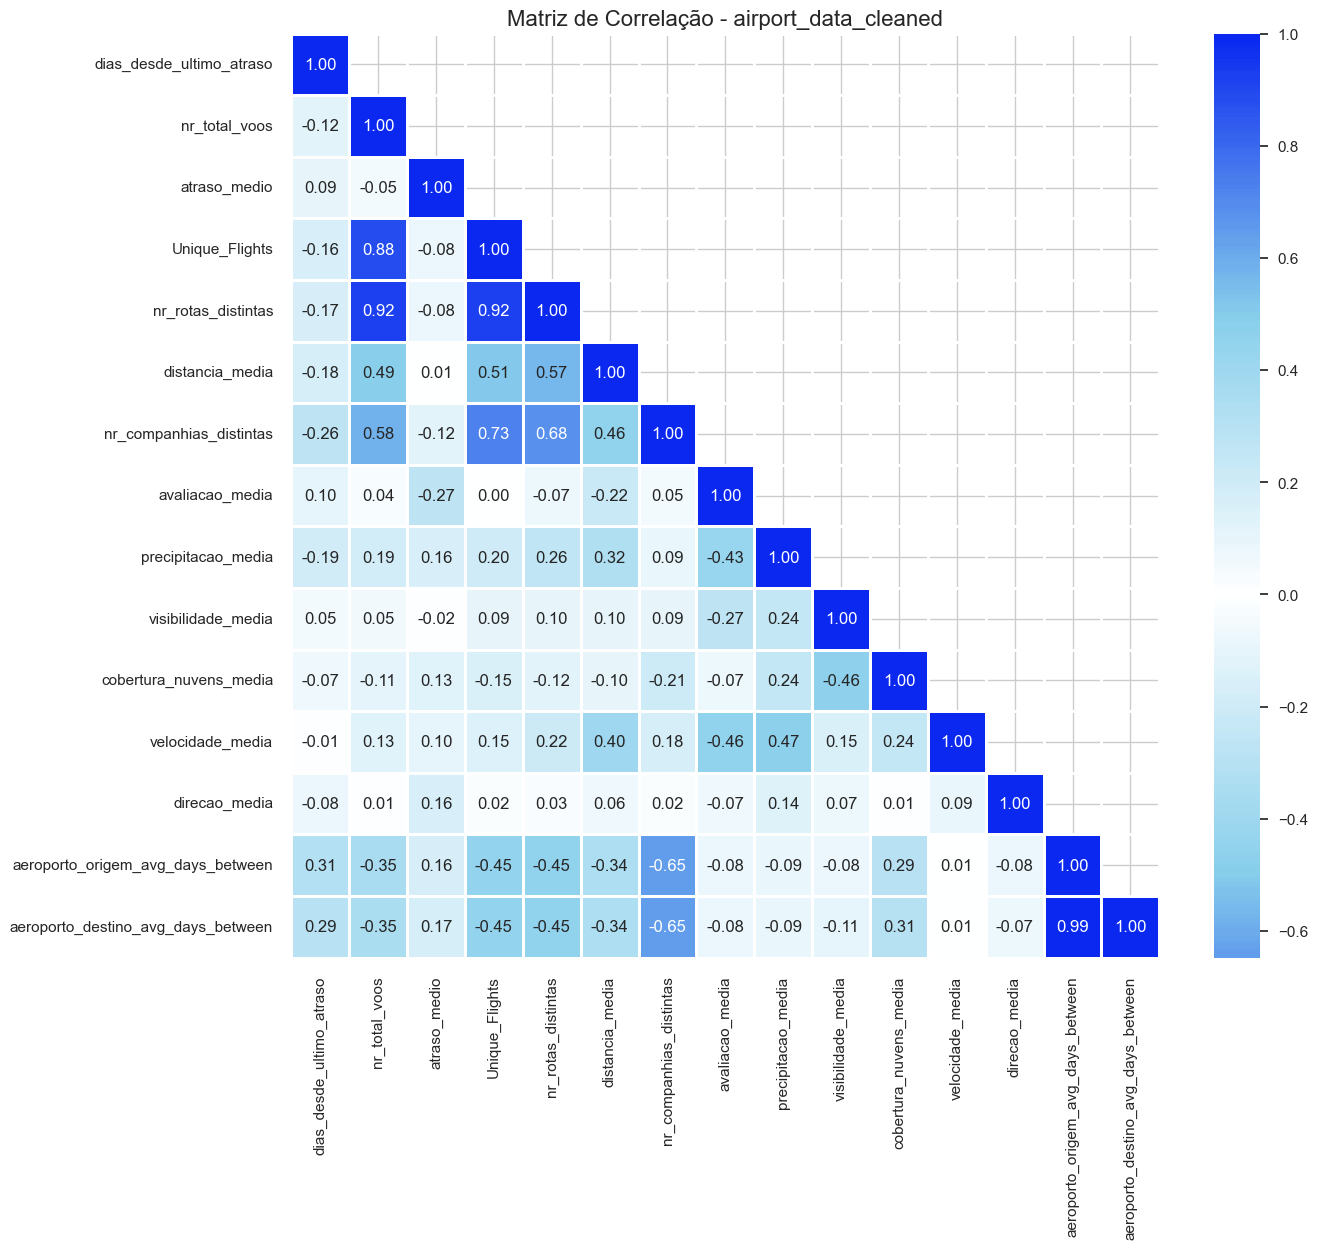

In [604]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Estilo do gráfico
sns.set_style('whitegrid')

# Selecionar apenas colunas numéricas
airport_numeric = airport_data_cleaned.select_dtypes(include=['float64', 'int64'])

# Calcular a matriz de correlação
corr = airport_numeric.corr()

# Definir o colormap personalizado
colors = ['#0a28f0', '#87CEEB', 'white', '#87CEEB', '#0a28f0']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Criar máscara para mostrar apenas o triângulo inferior
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot do heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Matriz de Correlação - airport_data_cleaned', fontsize=16)
plt.show()


In [605]:
airport_data_cleaned.drop(columns={'aeroporto_origem_avg_days_between','Unique_Flights'}, inplace=True)

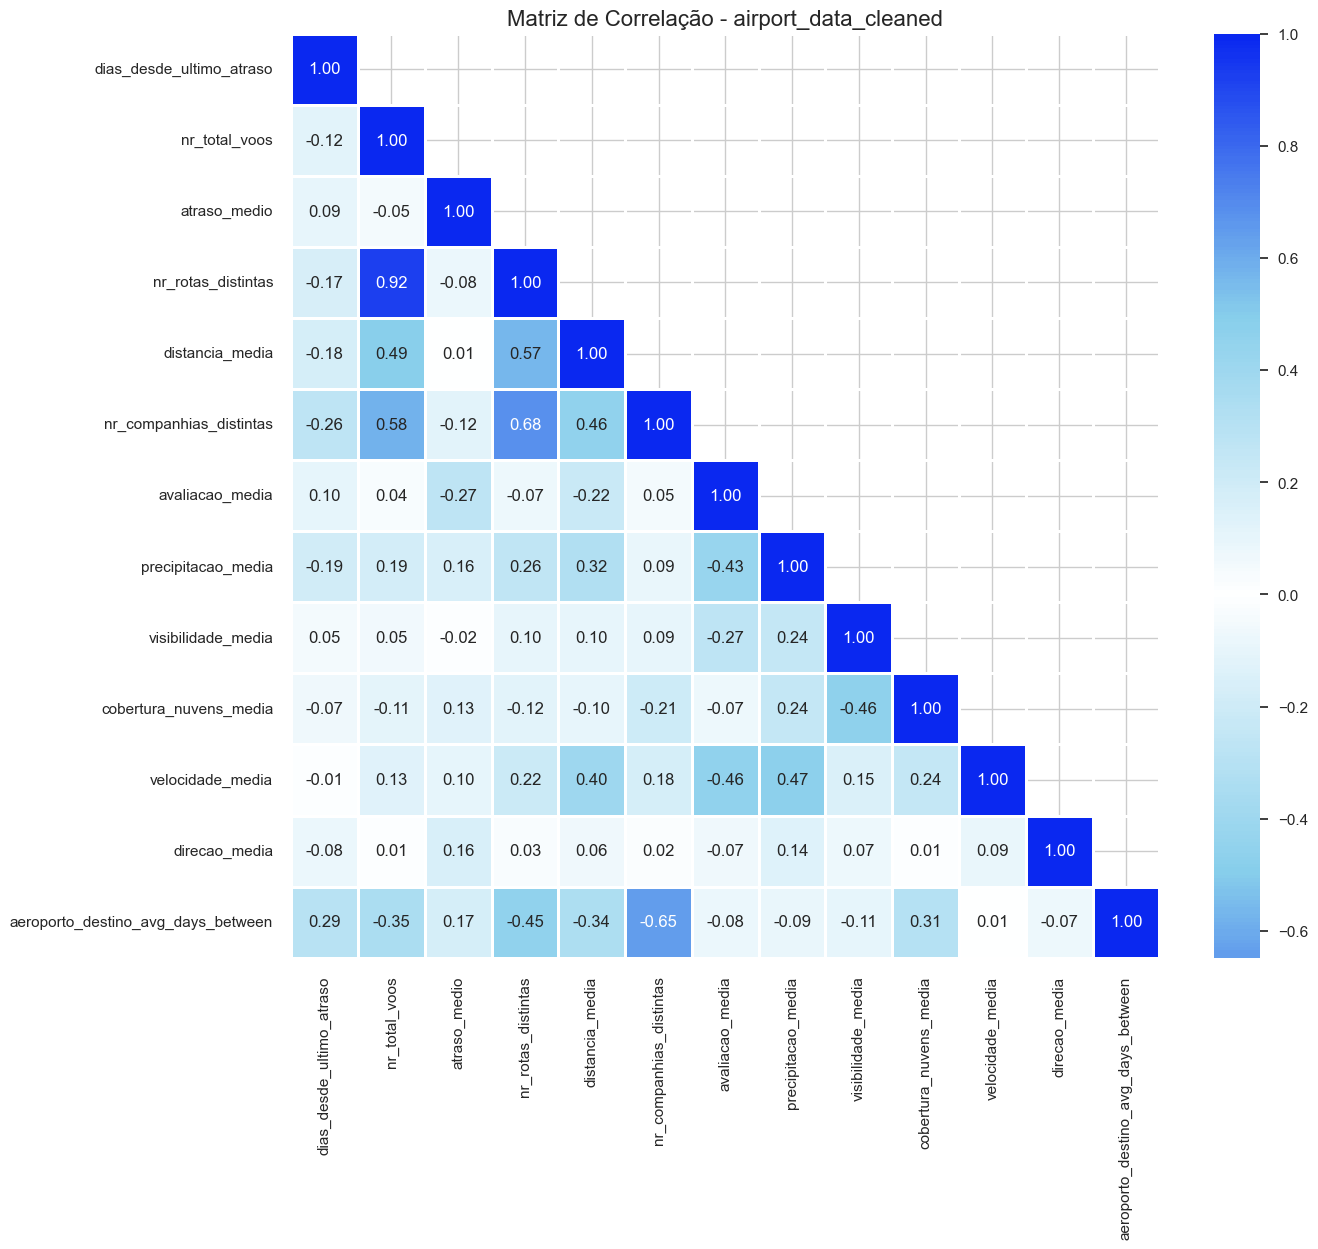

In [606]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Estilo do gráfico
sns.set_style('whitegrid')

# Selecionar apenas colunas numéricas
airport_numeric = airport_data_cleaned.select_dtypes(include=['float64', 'int64'])

# Calcular a matriz de correlação
corr = airport_numeric.corr()

# Definir o colormap personalizado
colors = ['#0a28f0', '#87CEEB', 'white', '#87CEEB', '#0a28f0']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Criar máscara para mostrar apenas o triângulo inferior
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot do heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Matriz de Correlação - airport_data_cleaned', fontsize=16)
plt.show()


<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 6 | Clustering</p>

In [607]:
airport_data_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
dias_desde_ultimo_atraso,359.0,42.958217,154.998616,0.000000,0.000000,2.000000,10.000000,1432.000000
nr_total_voos,359.0,12981.451253,28003.350303,81.000000,692.000000,2272.000000,9302.000000,184521.000000
atraso_medio,359.0,-4.983008,8.384107,-52.560000,-9.460000,-4.210000,-0.190000,47.170000
nr_rotas_distintas,359.0,38.091922,55.174886,2.000000,6.000000,14.000000,43.500000,308.000000
distancia_media,359.0,513.812266,286.347081,57.245866,302.783125,470.257028,649.350560,1923.735271
nr_companhias_distintas,359.0,6.183844,5.050545,1.000000,1.000000,5.000000,11.000000,17.000000
avaliacao_media,359.0,3.354591,0.320162,2.155754,3.339386,3.385014,3.411786,5.168889
precipitacao_media,359.0,3.762439,0.438564,2.442621,3.523665,3.688040,3.962315,5.549584
visibilidade_media,359.0,11.575731,0.144813,10.239390,11.542087,11.584624,11.632768,12.024446
cobertura_nuvens_media,359.0,26.161857,1.236635,22.476668,25.621169,25.966723,26.491416,36.106110


In [608]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['aeroporto',
                      'aeroporto_origem_peak_day',
                      'aeroporto_origem_peak_hour',
                      'aeroporto_origem_peak_month',
                      'aeroporto_destino_peak_day',
                      'aeroporto_destino_peak_hour',
                      'aeroporto_destino_peak_month'
                      ]

# Seleciona apenas colunas numéricas
numerical_cols = airport_data_cleaned.select_dtypes(include='number').columns.tolist()

# Remove colunas a excluir
columns_to_scale = [col for col in numerical_cols if col not in columns_to_exclude]

# Aplica o scaler
scaler = StandardScaler()
airport_data_scaled = airport_data_cleaned.copy()
airport_data_scaled[columns_to_scale] = scaler.fit_transform(airport_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
airport_data_scaled.head()

airport_data_scaled_original = airport_data_scaled
airport_data_cleaned_original = airport_data_cleaned

In [609]:


# Lista de colunas cíclicas
cyclic_columns = ['aeroporto_origem_peak_day',
                      'aeroporto_origem_peak_hour',
                      'aeroporto_origem_peak_month',
                      'aeroporto_destino_peak_day',
                      'aeroporto_destino_peak_hour',
                      'aeroporto_destino_peak_month']

# Criar cópia do dataset
#airport_data_scaled = airport_data_cleaned.copy()

cyclic_periods = {
    'aeroporto_destino_peak_day': 7,
    'aeroporto_destino_peak_month': 12,
    'aeroporto_destino_peak_hour': 24,
    'aeroporto_origem_peak_day': 7,
    'aeroporto_origem_peak_month': 12,
    'aeroporto_origem_peak_hour': 24
}

for col in cyclic_columns:
    period = cyclic_periods[col]
    airport_data_scaled[col] = np.sin(2 * np.pi * airport_data_scaled[col] / period)

# Visualizar os primeiros resultados
airport_data_scaled.head()

,aeroporto,dias_desde_ultimo_atraso,nr_total_voos,atraso_medio,nr_rotas_distintas,distancia_media,nr_companhias_distintas,avaliacao_media,precipitacao_media,visibilidade_media,cobertura_nuvens_media,velocidade_media,direcao_media,aeroporto_origem_peak_day,aeroporto_origem_peak_hour,aeroporto_origem_peak_month,aeroporto_destino_avg_days_between,aeroporto_destino_peak_day,aeroporto_destino_peak_hour,aeroporto_destino_peak_month
0,FLL,-0.277539,2.326663,-0.355571,2.757053,1.850736,1.351472,-0.023605,1.725092,-0.239091,0.386229,1.239644,0.129548,-0.781831,0.0,1.000000,-0.819999,-0.781831,0.0,1.000000
1,MSP,-0.277539,3.723228,0.174741,4.372357,0.957231,2.144571,0.108251,0.114023,-0.232837,-0.276463,-0.058637,-0.232619,0.000000,0.0,-0.866025,-0.824377,0.000000,0.0,-0.866025
2,MCO,-0.277539,3.963427,-0.439179,3.247089,1.600054,0.954922,0.113599,2.260767,0.278513,0.461513,1.317229,0.224286,-0.974928,0.0,1.000000,-0.824859,-0.974928,0.0,1.000000
3,DAL,-0.277539,1.640002,0.202213,2.121821,0.706140,-0.036452,0.129492,1.608789,0.576384,-0.330380,0.001208,0.526846,0.433884,0.0,-0.866025,-0.815649,-0.433884,0.0,-0.500000
4,DCA,-0.277539,3.217691,0.227295,2.974847,0.472061,1.549747,0.112071,0.324885,0.122292,-0.274419,0.619519,-0.000550,0.433884,0.0,1.000000,-0.823218,0.000000,0.0,0.500000


In [610]:
airport_data_scaled.describe().T


,count,mean,std,min,25%,50%,75%,max
dias_desde_ultimo_atraso,359.0,-1.979228e-17,1.001396,-0.277539,-0.277539,-2.646177e-01,-0.212932,8.974147
nr_total_voos,359.0,-3.958455e-17,1.001396,-0.461318,-0.439469,-3.829684e-01,-0.131577,6.134229
atraso_medio,359.0,4.948069e-17,1.001396,-5.682584,-0.534731,9.232793e-02,0.572476,6.229143
nr_rotas_distintas,359.0,0.000000e+00,1.001396,-0.655050,-0.582452,-4.372559e-01,0.098154,4.898692
distancia_media,359.0,-1.187537e-16,1.001396,-1.596676,-0.737998,-1.523187e-01,0.473996,4.930697
nr_companhias_distintas,359.0,1.187537e-16,1.001396,-1.027825,-1.027825,-2.347264e-01,0.954922,2.144571
avaliacao_media,359.0,-7.916911e-17,1.001396,-3.749701,-0.047559,9.515726e-02,0.178893,5.674727
precipitacao_media,359.0,1.929747e-16,1.001396,-3.013607,-0.545206,-1.698790e-01,0.456386,4.080679
visibilidade_media,359.0,-1.550230e-14,1.001396,-9.240919,-0.232657,6.149275e-02,0.394416,3.102901
cobertura_nuvens_media,359.0,-2.276112e-15,1.001396,-2.984172,-0.437835,-1.580147e-01,0.266868,8.052602


In [611]:
airport_data_scaled.head()

,aeroporto,dias_desde_ultimo_atraso,nr_total_voos,atraso_medio,nr_rotas_distintas,distancia_media,nr_companhias_distintas,avaliacao_media,precipitacao_media,visibilidade_media,cobertura_nuvens_media,velocidade_media,direcao_media,aeroporto_origem_peak_day,aeroporto_origem_peak_hour,aeroporto_origem_peak_month,aeroporto_destino_avg_days_between,aeroporto_destino_peak_day,aeroporto_destino_peak_hour,aeroporto_destino_peak_month
0,FLL,-0.277539,2.326663,-0.355571,2.757053,1.850736,1.351472,-0.023605,1.725092,-0.239091,0.386229,1.239644,0.129548,-0.781831,0.0,1.000000,-0.819999,-0.781831,0.0,1.000000
1,MSP,-0.277539,3.723228,0.174741,4.372357,0.957231,2.144571,0.108251,0.114023,-0.232837,-0.276463,-0.058637,-0.232619,0.000000,0.0,-0.866025,-0.824377,0.000000,0.0,-0.866025
2,MCO,-0.277539,3.963427,-0.439179,3.247089,1.600054,0.954922,0.113599,2.260767,0.278513,0.461513,1.317229,0.224286,-0.974928,0.0,1.000000,-0.824859,-0.974928,0.0,1.000000
3,DAL,-0.277539,1.640002,0.202213,2.121821,0.706140,-0.036452,0.129492,1.608789,0.576384,-0.330380,0.001208,0.526846,0.433884,0.0,-0.866025,-0.815649,-0.433884,0.0,-0.500000
4,DCA,-0.277539,3.217691,0.227295,2.974847,0.472061,1.549747,0.112071,0.324885,0.122292,-0.274419,0.619519,-0.000550,0.433884,0.0,1.000000,-0.823218,0.000000,0.0,0.500000


# <b></span><span style='color:#87CEEB'> PCA</span></b>


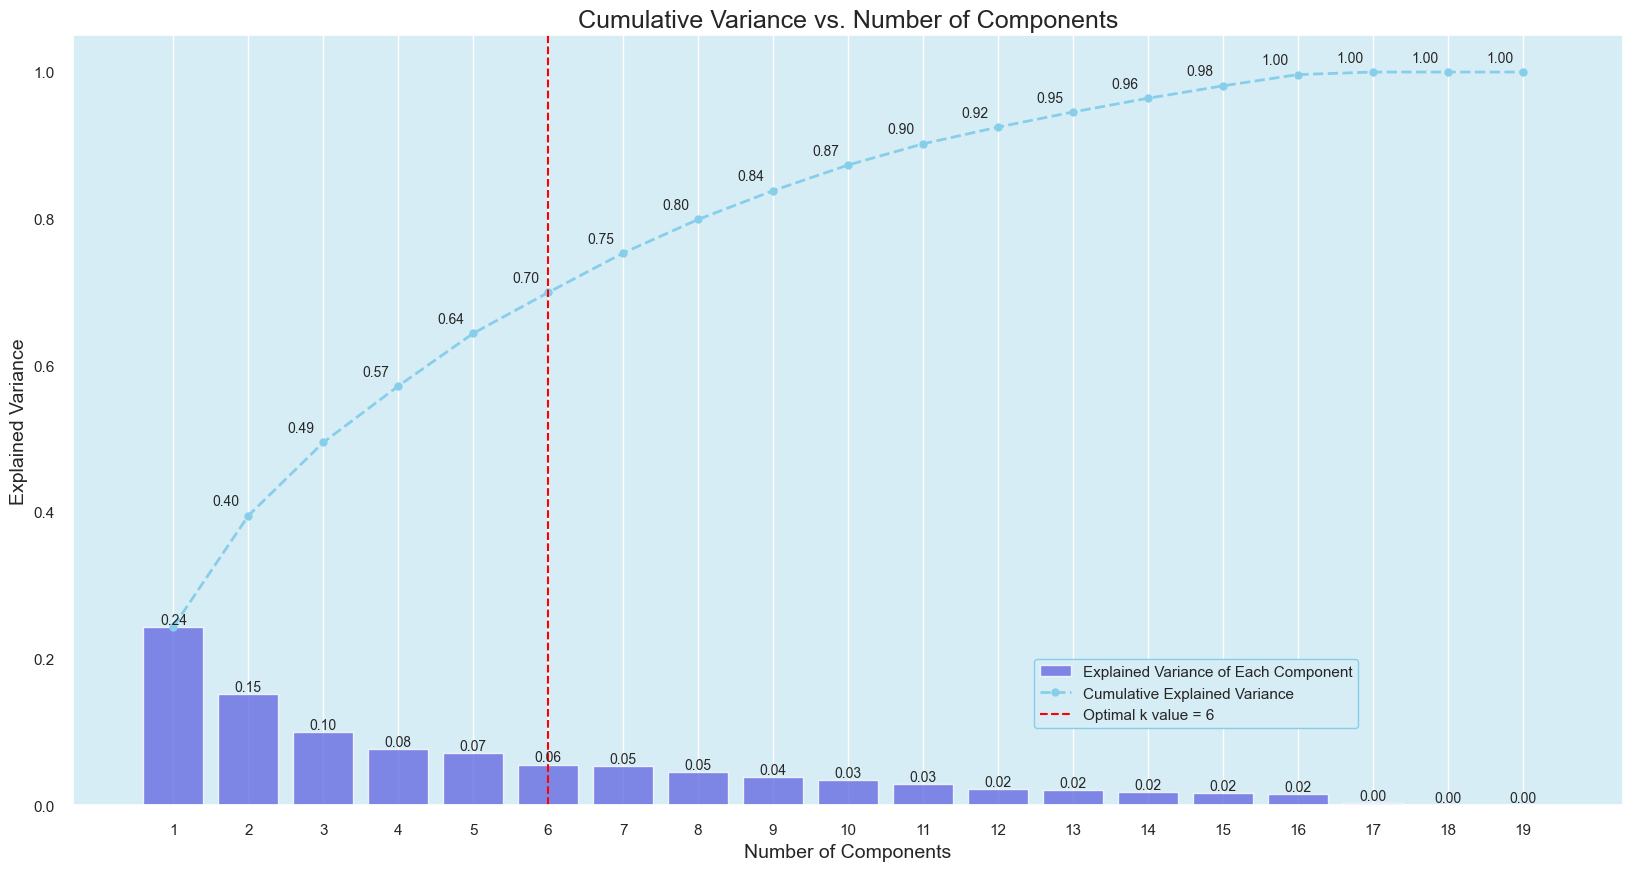

In [612]:
# Setting aeroporto as the index column
airport_data_scaled.set_index('aeroporto', inplace=True)

# Apply PCA
pca = PCA(svd_solver='randomized')
pca.fit(airport_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#d7edf5'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#535bf5',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#87CEEB', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#87CEEB')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [613]:
# Creating a PCA object with 8 components
pca = PCA(n_components=8)

# Fitting and transforming the original data to the new PCA dataframe
airport_data_pca = pca.fit_transform(airport_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
airport_data_pca = pd.DataFrame(airport_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
airport_data_pca.index = airport_data_scaled.index

In [614]:
# Displaying the resulting dataframe based on the PCs
airport_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
aeroporto,,,,,,,,
FLL,4.563681,-0.696509,-1.240950,-1.158371,0.096545,1.292966,0.070765,0.410266
MSP,5.099984,1.736775,-1.338134,-0.943087,2.011843,-0.922716,0.099004,1.676225
MCO,5.418341,-0.771234,-1.239453,-1.532964,0.505377,1.575083,-0.066035,1.679901
DAL,2.692751,-0.058407,0.011613,0.310912,0.894131,-0.278584,-0.411568,1.480221
DCA,4.112217,0.721966,-0.706255,-1.157016,0.973732,0.899559,0.801342,1.049882


# <b></span><span style='color:#87CEEB'> Elbow Method</span></b>


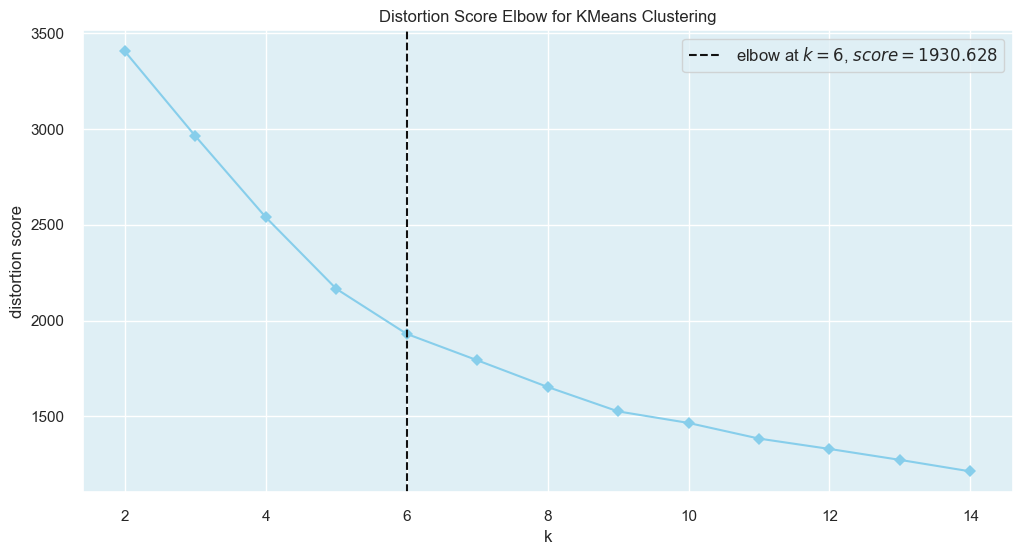

In [615]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#dfeff5'})

# Set the color palette for the plot
sns.set_palette(['#87CEEB'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 6))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(airport_data_pca)

# Finalize and render the figure
visualizer.show();

# <b></span><span style='color:#87CEEB'> Silhouette Method</span></b>


In [616]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

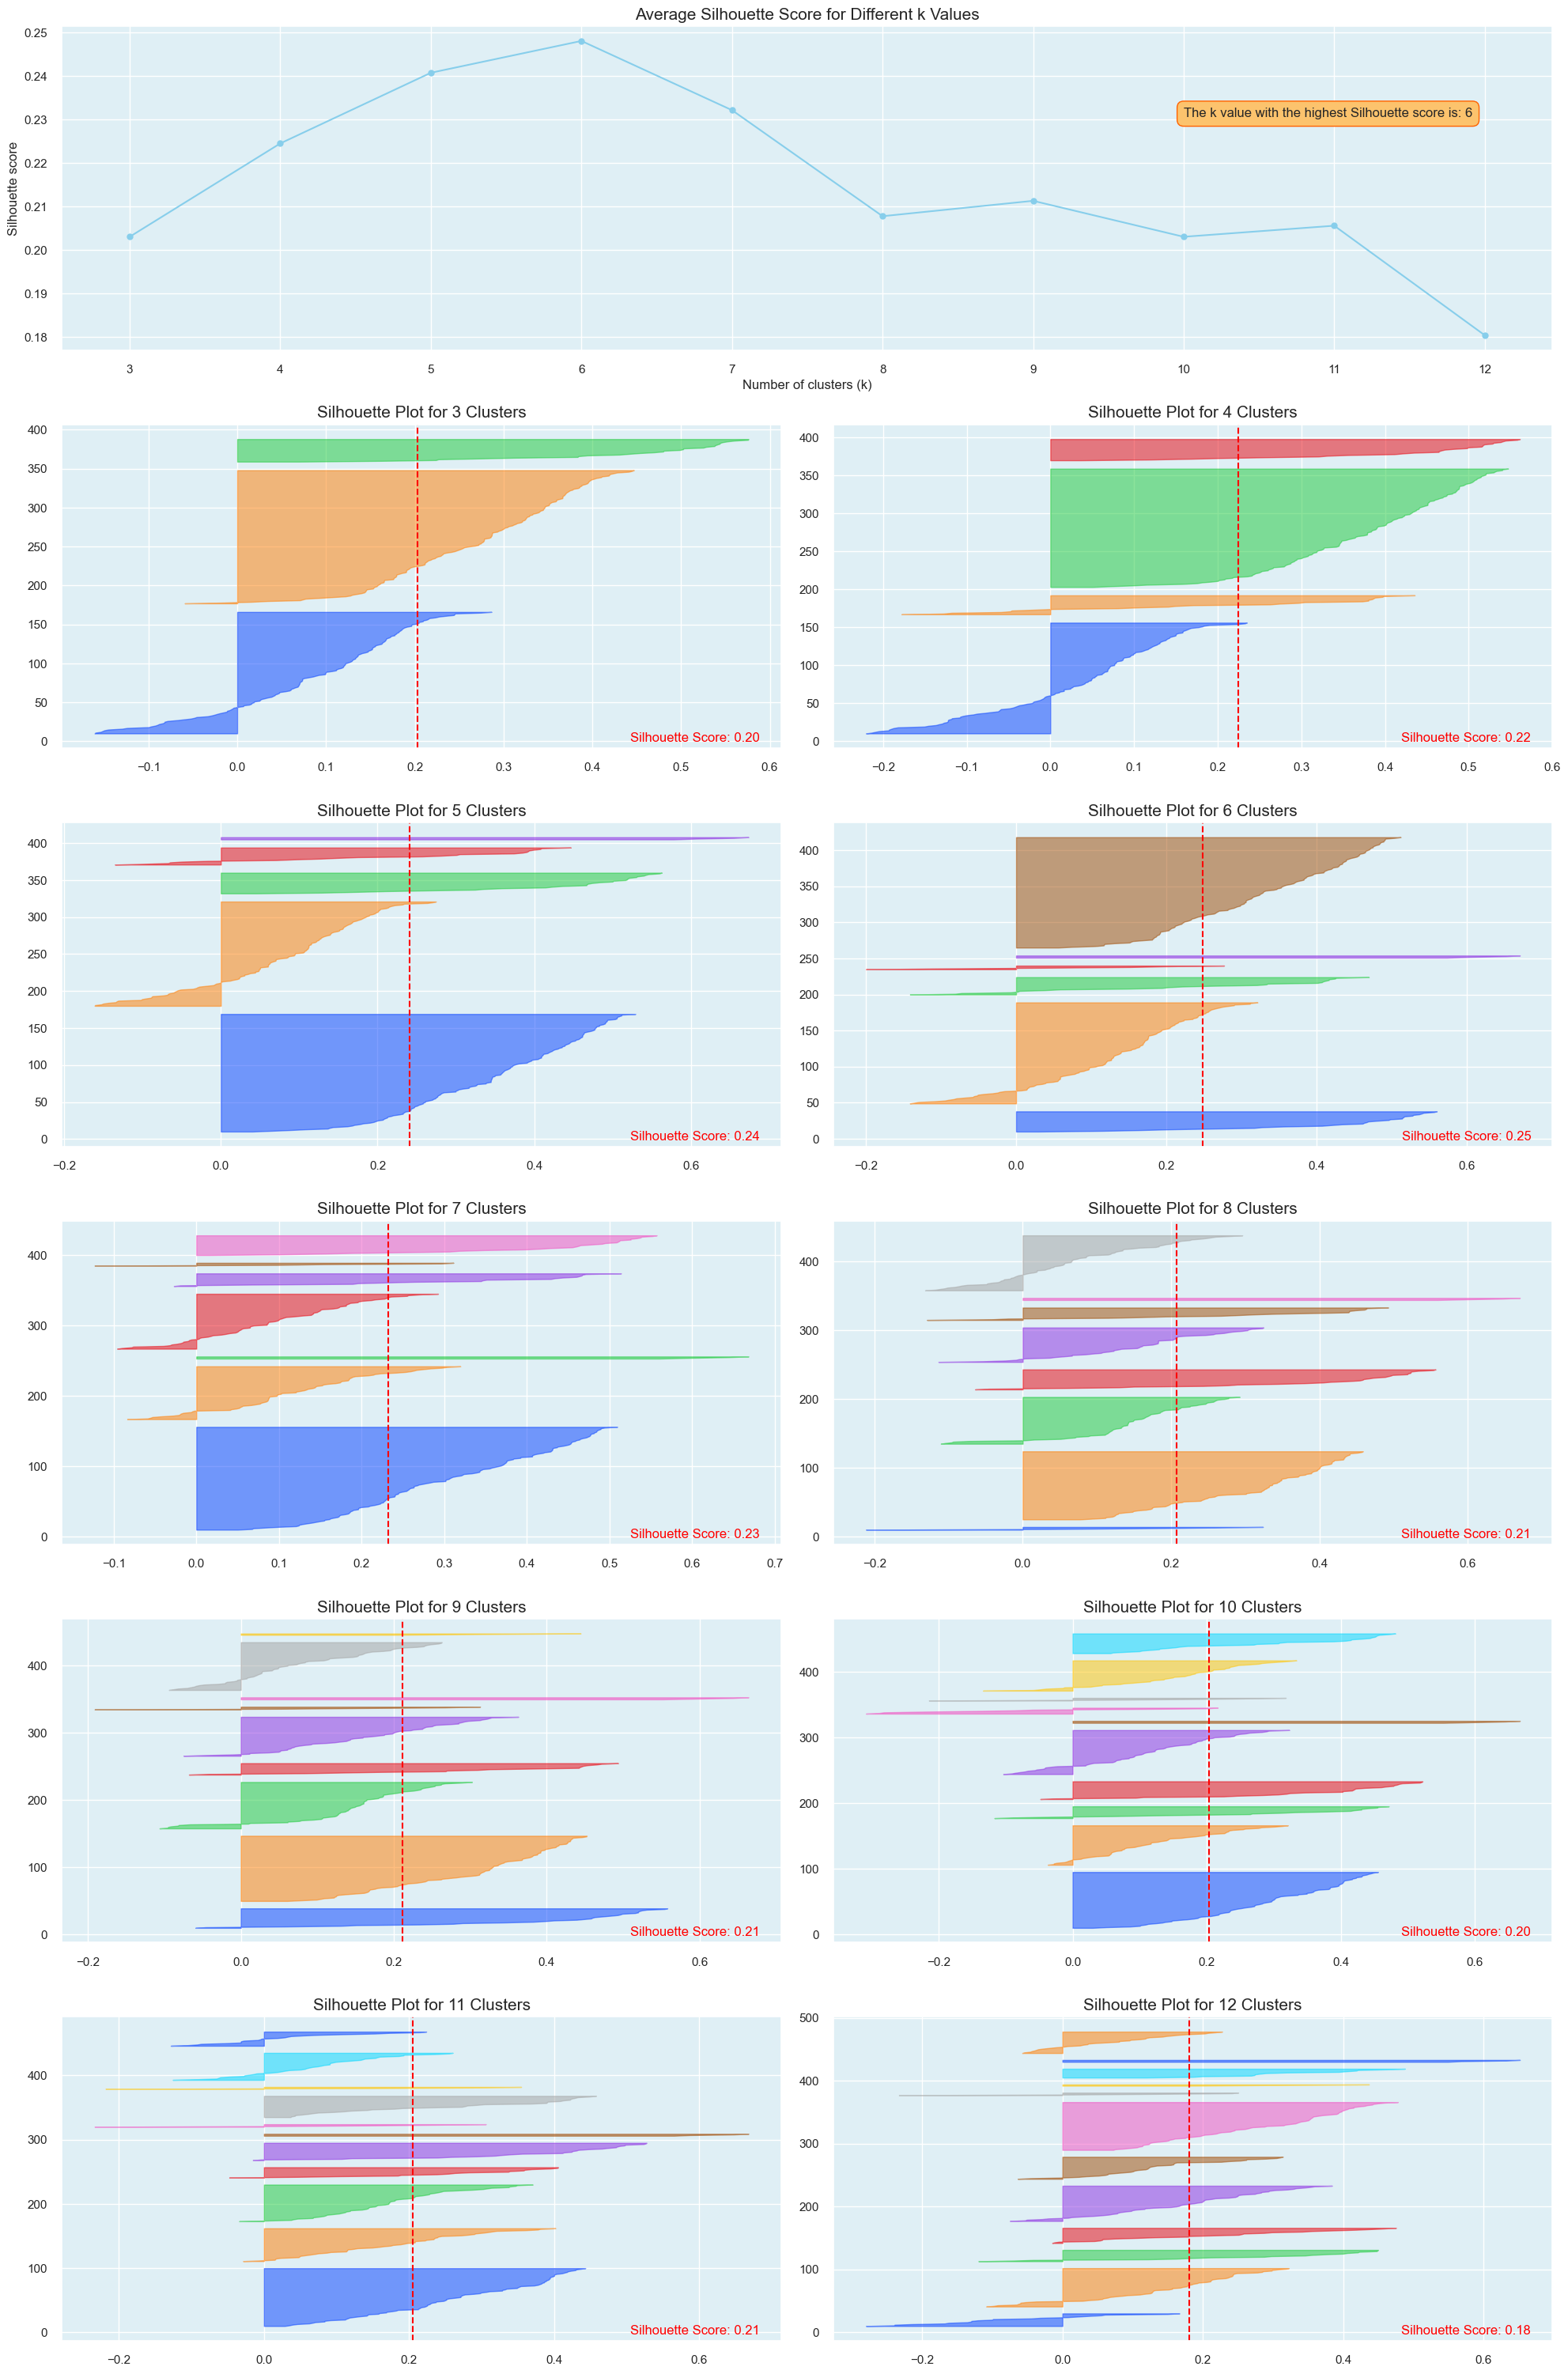

In [617]:
silhouette_analysis(airport_data_pca, 3, 12, figsize=(20, 50))


# <b></span><span style='color:#87CEEB'> Clustering Model K-means</span></b>


In [618]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(airport_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {4: 1, 3: 2, 2: 3, 1: 4, 0: 5, 5 : 0}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
airport_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
airport_data_pca['cluster'] = new_labels

In [619]:
airport_data_cleaned.head()


,aeroporto,dias_desde_ultimo_atraso,nr_total_voos,atraso_medio,nr_rotas_distintas,distancia_media,nr_companhias_distintas,avaliacao_media,precipitacao_media,visibilidade_media,...,velocidade_media,direcao_media,aeroporto_origem_peak_day,aeroporto_origem_peak_hour,aeroporto_origem_peak_month,aeroporto_destino_avg_days_between,aeroporto_destino_peak_day,aeroporto_destino_peak_hour,aeroporto_destino_peak_month,cluster
0,FLL,0,78045,-7.96,190,1043.026575,13,3.347044,4.517948,11.541156,...,16.251554,182.028636,6,0,3,0.043722,6,0,3,5
1,MSP,0,117099,-3.52,279,787.530555,17,3.389200,3.812376,11.542060,...,14.692232,180.302748,0,0,8,0.029164,0,0,8,5
2,MCO,0,123816,-8.66,217,971.344573,11,3.390910,4.752549,11.616008,...,16.344739,182.480104,5,0,3,0.027562,5,0,3,5
3,DAL,0,58843,-3.29,155,715.731498,6,3.395992,4.467013,11.659083,...,14.764110,183.921931,3,0,8,0.058188,4,0,7,5
4,DCA,0,102962,-3.08,202,648.797284,14,3.390422,3.904723,11.593416,...,15.506743,181.408657,3,0,3,0.033019,0,0,1,5


# <b></span><span style='color:#87CEEB'> Clustering Evaluation</span></b>


In [620]:
colors = ['#e8000b', '#1ac938', '#023eff', "#FFC0CB", "#964B00", '#87CEEB']

In [621]:
# Create separate data frames for each cluster
cluster_0 = airport_data_pca[airport_data_pca['cluster'] == 0]
cluster_1 = airport_data_pca[airport_data_pca['cluster'] == 1]
cluster_2 = airport_data_pca[airport_data_pca['cluster'] == 2]
cluster_3 = airport_data_pca[airport_data_pca['cluster'] == 3]
cluster_4 = airport_data_pca[airport_data_pca['cluster'] == 4]
cluster_5 = airport_data_pca[airport_data_pca['cluster'] == 5]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))
fig.add_trace(go.Scatter3d(x=cluster_3['PC1'], y=cluster_3['PC2'], z=cluster_3['PC3'], 
                           mode='markers', marker=dict(color=colors[3], size=5, opacity=0.4), name='Cluster 3'))
fig.add_trace(go.Scatter3d(x=cluster_4['PC1'], y=cluster_4['PC2'], z=cluster_4['PC3'], 
                           mode='markers', marker=dict(color=colors[4], size=5, opacity=0.4), name='Cluster 4'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of airport Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_28896\3470918287.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




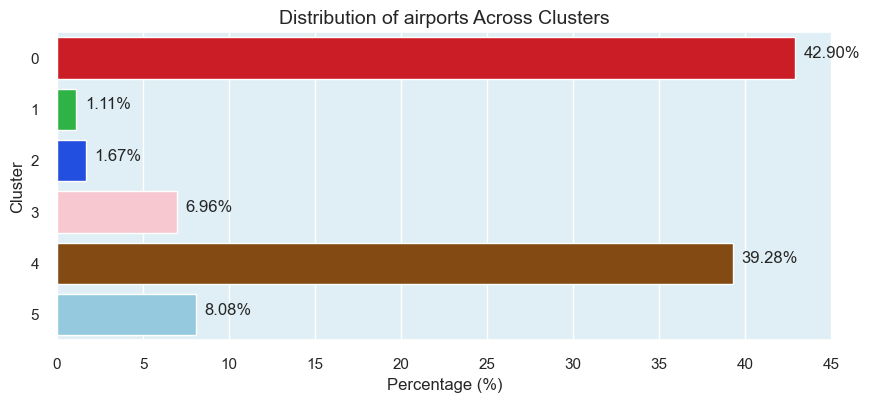

In [622]:
# Calculate the percentage of airports in each cluster
cluster_percentage = (airport_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of airports Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

In [623]:
# Compute number of customers
num_observations = len(airport_data_pca)

# Separate the features and the cluster labels
X = airport_data_pca.drop('cluster', axis=1)
clusters = airport_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |         359         |
|    Silhouette Score     | 0.24808612357978843 |
| Calinski Harabasz Score |  85.0784864741418   |
|  Davies Bouldin Score   | 1.1243012118339621  |
+-------------------------+---------------------+


# <b></span><span style='color:#87CEEB'> Cluster Analysis and Profiling</span></b>

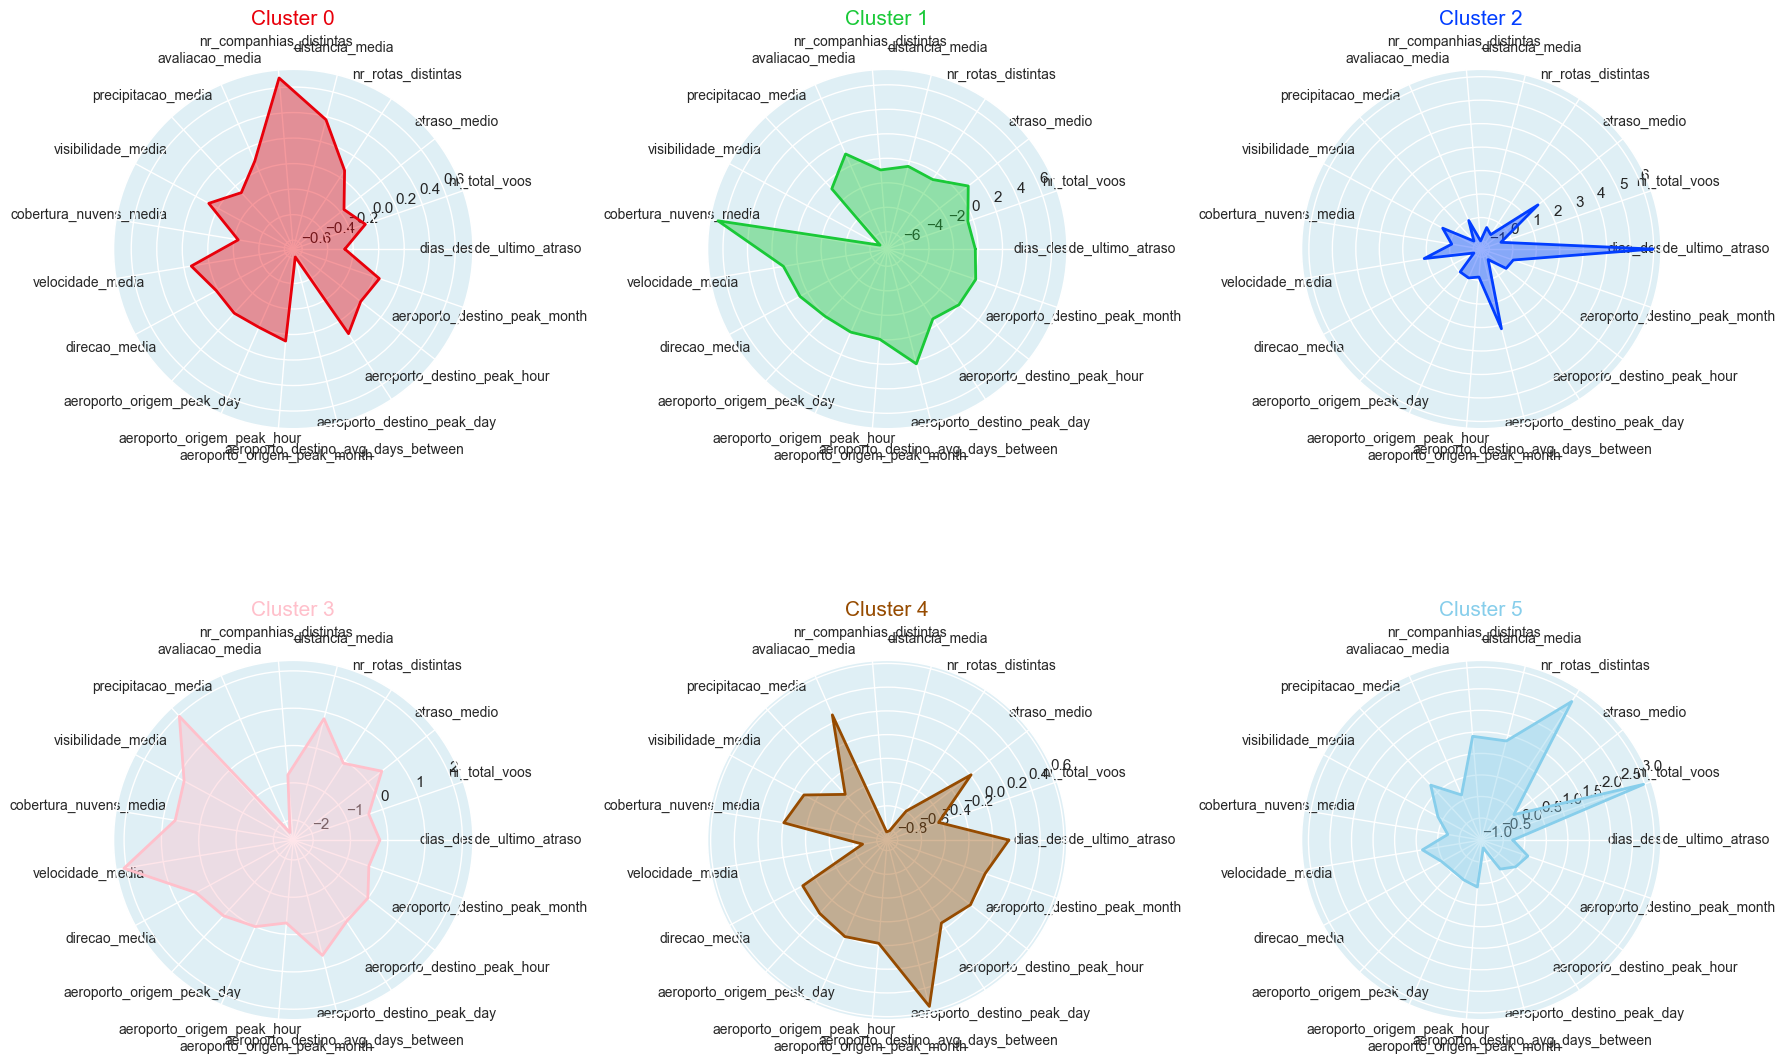

In [624]:
# Definir 'airportID' como índice
df_airport = airport_data_cleaned.set_index('aeroporto')

# Padronizar os dados (excluindo a coluna 'cluster')
scaler = StandardScaler()
df_airport_standardized = scaler.fit_transform(df_airport.drop(columns=['cluster'], axis=1))

# Criar um novo DataFrame padronizado e adicionar a coluna de cluster de volta
df_airport_standardized = pd.DataFrame(df_airport_standardized, columns=df_airport.columns[:-1], index=df_airport.index)
df_airport_standardized['cluster'] = df_airport['cluster']

# Calcular os centroides de cada cluster
cluster_centroids = df_airport_standardized.groupby('cluster').mean()

# Função para criar um gráfico de radar
def create_radar_chart(ax, angles, data, color, cluster):
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    ax.set_title(f'Cluster {cluster}', size=15, color=color, y=1.1)

# Definir os rótulos das variáveis
labels = np.array(cluster_centroids.columns)
num_vars = len(labels)

# Calcular os ângulos para cada eixo do gráfico de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Completar o ciclo para fechar o gráfico de radar
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Criar a figura para 5 clusters
fig, ax = plt.subplots(figsize=(18, 12), subplot_kw=dict(polar=True), nrows=2, ncols=3)

ax = ax.flatten()

# Criar gráficos de radar para cada cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Fechar o loop
    create_radar_chart(ax[i], angles, data, color, i)
    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(labels[:-1], fontsize=10)

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()

[0 1 2 3 4 5]


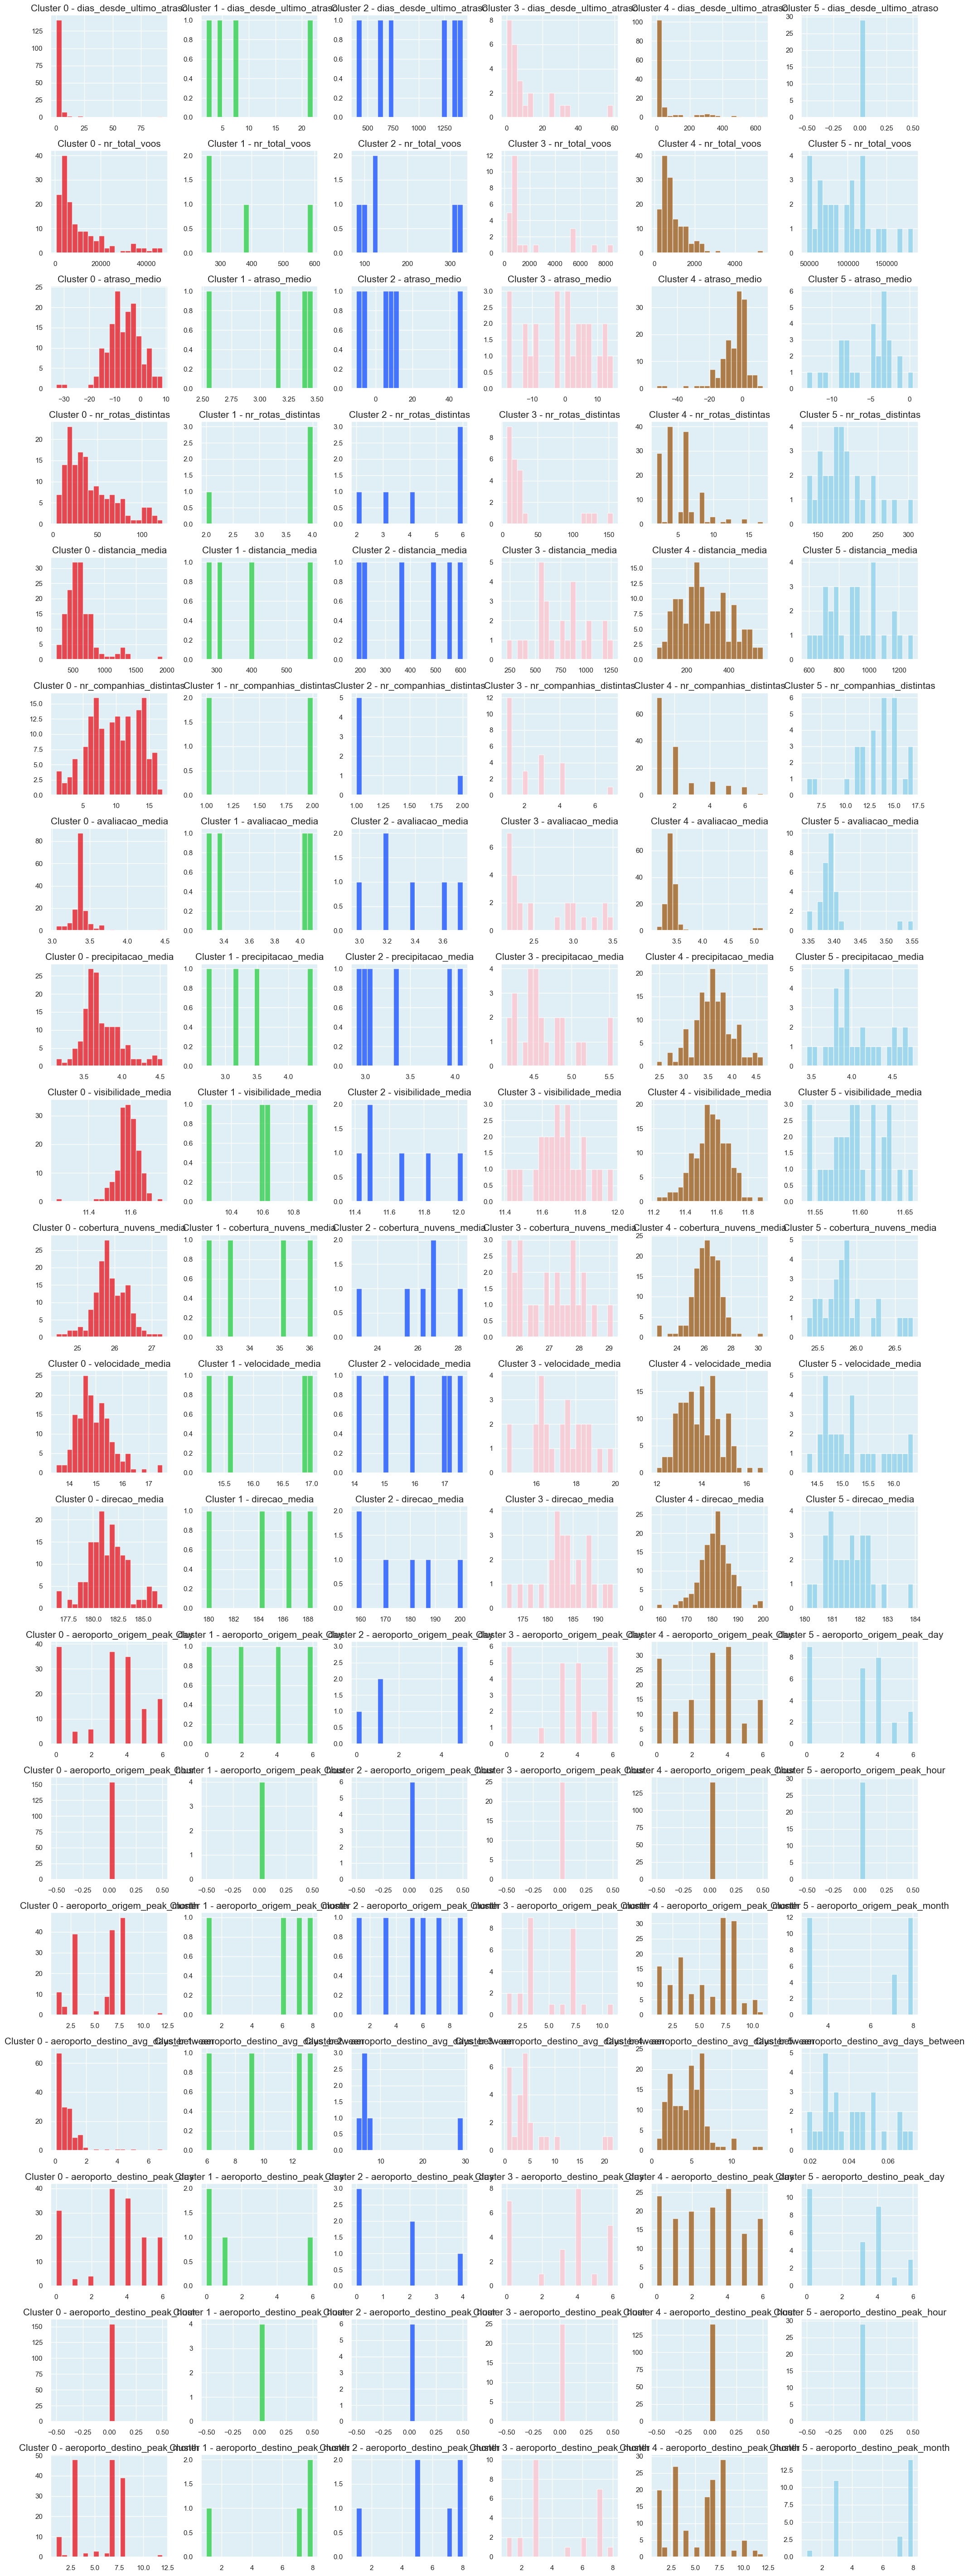

In [625]:
# Plot histograms for each feature segmented by the clusters
features = airport_data_cleaned.columns[1:-1]
clusters = airport_data_cleaned['cluster'].unique()
clusters.sort()

print(clusters)

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = airport_data_cleaned[airport_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 7 | Recomendation System</p>

# <b></span><span style='color:#87CEEB'> Cluster Analysis and Profiling</span></b>


# <b></span><span style='color:#87CEEB'> Recomendações baseada nas preferências do cluster</span></b>


In [626]:
rs = df_flights_clean.copy()

rs.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2912365 entries, 0 to 2999999
Data columns (total 42 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   nr_voo                       int64         
 1   data_partida                 datetime64[ns]
 2   nome_companhia_aerea         object        
 3   id_companhia_aerea           object        
 4   pais_companhia_aerea         object        
 5   aeroporto_origem             object        
 6   nome_aeroporto_origem        object        
 7   pais_aeroporto_origem        object        
 8   cidade_aeroporto_origem      object        
 9   latitude_aeroporto_origem    float64       
 10  longitude_aeroporto_origem   float64       
 11  aeroporto_destino            object        
 12  nome_aeroporto_destino       object        
 13  pais_aeroporto_destino       object        
 14  cidade_aeroporto_destino     object        
 15  latitude_aeroporto_destino   float64       
 16  longi

In [627]:
airport_data_cleaned = airport_data_cleaned.reset_index()

In [628]:
airport_data_cleaned.head()

,index,aeroporto,dias_desde_ultimo_atraso,nr_total_voos,atraso_medio,nr_rotas_distintas,distancia_media,nr_companhias_distintas,avaliacao_media,precipitacao_media,...,velocidade_media,direcao_media,aeroporto_origem_peak_day,aeroporto_origem_peak_hour,aeroporto_origem_peak_month,aeroporto_destino_avg_days_between,aeroporto_destino_peak_day,aeroporto_destino_peak_hour,aeroporto_destino_peak_month,cluster
0,0,FLL,0,78045,-7.96,190,1043.026575,13,3.347044,4.517948,...,16.251554,182.028636,6,0,3,0.043722,6,0,3,5
1,1,MSP,0,117099,-3.52,279,787.530555,17,3.389200,3.812376,...,14.692232,180.302748,0,0,8,0.029164,0,0,8,5
2,2,MCO,0,123816,-8.66,217,971.344573,11,3.390910,4.752549,...,16.344739,182.480104,5,0,3,0.027562,5,0,3,5
3,3,DAL,0,58843,-3.29,155,715.731498,6,3.395992,4.467013,...,14.764110,183.921931,3,0,8,0.058188,4,0,7,5
4,4,DCA,0,102962,-3.08,202,648.797284,14,3.390422,3.904723,...,15.506743,181.408657,3,0,3,0.033019,0,0,1,5


# <b></span><span style='color:#87CEEB'> Recomenda rotas com base no aeroporto dado</span></b>


In [629]:
def recomendar_voos(airport_id):
    # Garantir que o aeroporto existe
    if airport_id not in airport_data_cleaned['aeroporto'].values:
        print(f"Aeroporto {airport_id} não encontrado.")
        return None

    # 1. Obter o cluster do Aeroporto
    cluster_id = airport_data_cleaned.loc[airport_data_cleaned['aeroporto'] == airport_id, 'cluster'].values[0]
    
    # 2. Obter todos os Aeroportos do mesmo cluster
    cluster_airports = airport_data_cleaned[airport_data_cleaned['cluster'] == cluster_id]['aeroporto'].unique()
    # 3. Filtrar todas as voos desses Aeroportos
    cluster_voos = rs[rs['aeroporto_origem'].isin(cluster_airports)]
    
    # 4. Agrupar por produto e fazer a media deatrasos
    voos_cluster = cluster_voos.groupby(['rota'])[['atraso_partida']].mean().reset_index()
    voos_cluster.columns = ['rota', 'atraso_partida']
    
    # 5. Ordenar pelos voos com menos atrasos
    voos_cluster = voos_cluster.sort_values(by='atraso_partida', ascending=True)
    
    
    # 8. Retornar top 10
    return voos_cluster.head(10)

In [630]:
recomendar_voos(airport_id='FLL')


,rota,atraso_partida
1825,MIA-HSV,-759.000000
910,FLL-BQN,-273.913295
793,DTW-TTN,-259.000000
1431,LAX-JAX,-241.675676
2042,PDX-FLL,-214.681818
1307,JFK-BQN,-187.338710
2656,SLC-RSW,-175.666667
2489,SFO-BDL,-167.875000
2550,SFO-PIT,-156.860656
178,BNA-TTN,-154.866667


# <b></span><span style='color:#87CEEB'> Recomenda companhias aereas com base no aeroporto dado</span></b>


In [631]:
def recomendar_airlines(airport_id):
    # Garantir que o aeroporto existe
    if airport_id not in airport_data_cleaned['aeroporto'].values:
        print(f"Aeroporto {airport_id} não encontrado.")
        return None

    # 1. Obter o cluster do Aeroporto
    cluster_id = airport_data_cleaned.loc[airport_data_cleaned['aeroporto'] == airport_id, 'cluster'].values[0]
    
    # 2. Obter todos os Aeroportos do mesmo cluster
    cluster_airports = airport_data_cleaned[airport_data_cleaned['cluster'] == cluster_id]['aeroporto'].unique()
    # 3. Filtrar todas as airlines desses Aeroportos
    cluster_airlines = rs[rs['aeroporto_origem'].isin(cluster_airports)]
    
    # 4. Agrupar por produto e fazer a media deatrasos
    airlines_cluster = cluster_airlines.groupby(['id_companhia_aerea', 'nome_companhia_aerea'])[['atraso_partida']].mean().reset_index()
    airlines_cluster.columns = ['id_companhia_aerea', 'nome_companhia_aerea', 'atraso_partida']
    
    # 5. Ordenar pelos airlines com menos atrasos
    airlines_cluster = airlines_cluster.sort_values(by='atraso_partida', ascending=True)
    
    
    # 8. Retornar top 10
    return airlines_cluster.head(10)

In [632]:
recomendar_airlines(airport_id='FLL')

,id_companhia_aerea,nome_companhia_aerea,atraso_partida
3,B6,JetBlue Airways,-3.357697
6,F9,Frontier Airlines,-2.565744
10,NK,Spirit Airlines,-1.203460
14,UA,United Airlines,-0.462982
2,AS,Alaska Airlines,1.683624
4,DL,Delta Air Lines,2.016389
0,9E,Pinnacle Airlines,2.048087
17,YX,Midwest Airlines,2.221317
1,AA,American Airlines,2.429236
11,OH,Comair,3.166493


# <b></span><span style='color:#87CEEB'> Recomendação Cascade</span></b>


In [ ]:
import lightgbm as lgb

clusters = [0, 1, 2, 3, 4, 5]

# Filtrar os aeroportos que estão nesses clusters
df_candidates = airport_data_cleaned[airport_data_cleaned['cluster'].isin(clusters)].copy()

# Critérios de filtragem quantitativa (exemplo - ajusta limites conforme teus dados)
criterios = (
    (df_candidates['atraso_medio'] < 10) &
    (df_candidates['precipitacao_media'] < 5) &
    (df_candidates['nr_total_voos'] > 1000)
)

df_candidates = df_candidates[criterios]

print(f'Aeroportos candidatos após filtragem: {len(df_candidates)}')

# 2. Preparar features para o modelo ranking
features = ['atraso_medio', 'precipitacao_media', 'nr_total_voos', 'cluster']

X = df_candidates[features]

# Normalizar (pode ajudar o modelo)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Criar variável alvo para ranking (quanto menor atraso, melhor)
# Neste exemplo, usa-se -atraso_medio como score (quanto maior, melhor)
y = -df_candidates['atraso_medio'].values

# 4. Treinar modelo LightGBM Ranker
# Como exemplo, usa todo o conjunto como um único grupo
group = [len(df_candidates)]

model = lgb.LGBMRegressor(n_estimators=100)
model.fit(X_scaled, y)


# 5. Prever score e ordenar aeroportos
scores = model.predict(X_scaled)
df_candidates['score'] = scores
df_recomendado = df_candidates.sort_values(by='score', ascending=False)

In [ ]:
# 6. Mostrar recomendações finais
df_recomendado[['aeroporto', 'cluster', 'atraso_medio', 'score']]

<a id="feature_engineering"></a>
# <p style="background-color: #87CEEB; font-family:calibri; color:black; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 8 | Prediction system</p>

In [650]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Features relevantes
features = ['temperatura', 'distancia', 
            'precipitacao', 'visibilidade', 
            'cobertura_nuvens', 'velocidade',
            'Hour', 'Month', 'Day_Of_Week']

# Target
target = 'atraso_partida'

aeroporto = 'FLL'
df_model = rs[rs['aeroporto_origem'] == aeroporto].copy()

# Filtrar dados de voos
df_model = rs.copy()

# Remover valores nulos (pode fazer tratamento melhor depois)
df_model = df_model.dropna(subset=features + [target])

# Separar X e y
X = df_model[features]
y = df_model[target]

# Treino/teste split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [651]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)


model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [652]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')


RMSE: 88.0969
MAE: 18.0794
R²: 0.0270


In [653]:
# Exemplo de previsão com novos dados
novo_voo = pd.DataFrame([{
    'temperatura': 22, 
    'distancia' : 1200, 
    'precipitacao' : 2.1,
    'visibilidade' : 11, 
    'cobertura_nuvens' : 25,
    'velocidade' : 13,
    'Hour' : 12,
    'Month' : 6,
    'Day_Of_Week' : 5
}])


# Prever atraso
atraso_previsto = model.predict(novo_voo)
print(f"Atraso previsto: {atraso_previsto[0]:.2f} minutos")

Atraso previsto: -0.60 minutos
